<a href="https://colab.research.google.com/github/nguyenkevin-dotcom/MLPremierLeague/blob/main/BP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktická část bakalářské práce**

Získání dat z Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Tvorba datasetu**

načtení knihoven

In [2]:
import pandas as pd
import numpy as np

## **Data**

In [3]:
# Datasety jednotlivých sezón Premier League od 2013 do 2025
pl24 = pd.read_csv("/content/drive/MyDrive/BP/E11.csv")
pl23 = pd.read_csv("/content/drive/MyDrive/BP/E0.csv")
pl22 = pd.read_csv("/content/drive/MyDrive/BP/E1.csv")
pl21 = pd.read_csv("/content/drive/MyDrive/BP/E2.csv")
pl20 = pd.read_csv("/content/drive/MyDrive/BP/E3.csv")
pl19 = pd.read_csv("/content/drive/MyDrive/BP/E4.csv")
pl18 = pd.read_csv("/content/drive/MyDrive/BP/E5.csv")
pl17 = pd.read_csv("/content/drive/MyDrive/BP/E6.csv")
pl16 = pd.read_csv("/content/drive/MyDrive/BP/E7.csv")
pl15 = pd.read_csv("/content/drive/MyDrive/BP/E8.csv")
pl14 = pd.read_csv("/content/drive/MyDrive/BP/E9.csv")
pl13 = pd.read_csv("/content/drive/MyDrive/BP/E10.csv")
# Sjednocení jednotlivých datasetů do jednoho velkého datasetu
pl1324 = pd.concat([pl13, pl14, pl15, pl16, pl17, pl18, pl19, pl20, pl21, pl22, pl23, pl24], ignore_index=True)
pl1324.to_csv("/content/drive/MyDrive/BP/pl1324.csv", index=False)

informace surových dat

In [4]:
pl1324.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4561 entries, 0 to 4560
Columns: 156 entries, Div to BFECAHA
dtypes: float64(148), object(8)
memory usage: 5.4+ MB


##**Předzpracování dat v datasetu**


In [5]:
# Načtení datasetu
pl = pd.read_csv("/content/drive/MyDrive/BP/pl1324.csv")
# Odstranění sloupců od sloupce s indexem 23 a výš
pl.drop(pl.columns[23:], axis=1, inplace=True)
# Odstranění sloupce Div a Referee
pl0 = pl.drop(["Div","Referee"], axis=1)

#Odstranění prázdných hodnot a resetování indexu
pl0.dropna(inplace=True)
pl0.reset_index(drop=True, inplace=True)

#Převod vybraných sloupců na int64
sloupce_k_prevodu = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
pl0[sloupce_k_prevodu] = pl0[sloupce_k_prevodu].astype(int)

# Převedení sloupce Date na odpovídající datový typ
pl0["Date"] = pd.to_datetime(pl0["Date"], format='%d/%m/%Y')

#Počet střel mimo branku
pl0["HSOT"] = pl0["HS"] - pl0["HST"]
pl0["ASOT"] = pl0["AS"] - pl0["AST"]
# Hrací týdny (1 až 38 v jedné sezóně)
pl0['Matchweek'] = ((pl0.index // 10) % 38) + 1

# Název týmu, který vyhrál
pl0["FTR - team"] = pl0.apply(lambda row: row["HomeTeam"] if row["FTR"] == "H" else (row["AwayTeam"] if row["FTR"] == "A" else "Draw"), axis=1)

# Sezóna
def get_season(Date): # přiřazení sezóny
  if Date.month >= 8: #srpen nebo později
    return f"{Date.year} - {Date.year + 1}"
  else: #leden do července
    return f"{Date.year - 1} - {Date.year}"

#Přidání sezóny
pl0["Season"] = pl0["Date"].apply(get_season)

# Rok začínání sezóny
pl0['Season_start_year'] = pl0['Season'].astype(str).str[:4].astype(int)

In [6]:
pl0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               4560 non-null   datetime64[ns]
 1   HomeTeam           4560 non-null   object        
 2   AwayTeam           4560 non-null   object        
 3   FTHG               4560 non-null   int64         
 4   FTAG               4560 non-null   int64         
 5   FTR                4560 non-null   object        
 6   HTHG               4560 non-null   int64         
 7   HTAG               4560 non-null   int64         
 8   HTR                4560 non-null   object        
 9   HS                 4560 non-null   int64         
 10  AS                 4560 non-null   int64         
 11  HST                4560 non-null   int64         
 12  AST                4560 non-null   int64         
 13  HF                 4560 non-null   int64         
 14  AF      

### **Vytváření předzápasové atributy (z posledních 4 zápasů)**

### kalkulace klouzavých průměrů

In [7]:
def calculate_avg_home_goals(df):
    """
      Vypočítává průměrný počet domácích gólů pro každý tým za poslední 4 zápasy,
      resetuje každých 38 zápasových týdnů.
    """
    avg_home_goals = []
    for index, row in df.iterrows():
        team = row['HomeTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 domácí zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_home_games = df[
            (df['HomeTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_home_games) == 0:
            avg_home_goals.append(0)
        else:
            avg = team_home_games['FTHG'].mean()
            avg_home_goals.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_home_goals)


def calculate_avg_away_goals(df):
    """
      Vypočítává průměrný počet hostujících gólů pro každý tým za poslední 4 zápasy,
      resetuje každých 38 zápasových týdnů.
    """
    avg_away_goals = []
    for index, row in df.iterrows():
        team = row['AwayTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_away_games = df[
            (df['AwayTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_away_games) == 0:
            avg_away_goals.append(0)
        else:
            avg = team_away_games['FTAG'].mean()
            avg_away_goals.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_away_goals)

def calculate_avg_HS(df):
    """
      Vypočítává průměrný počet domácích střel na bránu pro každý tým za poslední 4 zápasy,
      resetuje každých 38 zápasových týdnů.
    """
    avg_HS = []
    for index, row in df.iterrows():
        team = row['HomeTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_home_games = df[
            (df['HomeTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_home_games) == 0:
            avg_HS.append(0)
        else:
            avg = team_home_games['HS'].mean()
            avg_HS.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_HS)


def calculate_avg_AS(df):
    """
      Vypočítává průměrný počet hostujících střel pro každý tým za poslední 4 zápasy,
      resetuje každých 38 zápasových týdnů.
    """
    avg_AS = []
    for index, row in df.iterrows():
        team = row['AwayTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_away_games = df[
            (df['AwayTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_away_games) == 0:
            avg_AS.append(0)
        else:
            avg = team_away_games['AS'].mean()
            avg_AS.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_AS)



def calculate_avg_HST(df):
    """
      Vypočítává průměrný počet domácích střel na bránu pro každý tým za poslední 4 zápasy,
      resetuje každých 38 zápasových týdnů.
    """
    avg_HST = []
    for index, row in df.iterrows():
        team = row['HomeTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_home_games = df[
            (df['HomeTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_home_games) == 0:
            avg_HST.append(0)
        else:
            avg = team_home_games['HST'].mean()
            avg_HST.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_HST)


def calculate_avg_AST(df):
    """
      Vypočítává průměrný počet hostujících střel na bránu pro každý tým za poslední 4 zápasy,
      resetuje každých 38 zápasových týdnů.
    """
    avg_AST = []
    for index, row in df.iterrows():
        team = row['AwayTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_away_games = df[
            (df['AwayTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_away_games) == 0:
            avg_AST.append(0)
        else:
            avg = team_away_games['AST'].mean()
            avg_AST.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_AST)

def calculate_avg_HGConceded(df):
    """
      Vypočítává průměrný počet obdržených gólů pro každý tým za poslední 4 zápasy, kde daný tým hrál na domácí půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_HGConceded = []
    for index, row in df.iterrows():
        team = row['HomeTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_home_games = df[
            (df['HomeTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_home_games) == 0:
            avg_HGConceded.append(0)
        else:
            avg = team_home_games['FTAG'].mean()
            avg_HGConceded.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_HGConceded)

def calculate_avg_AGConceded(df):
    """
      Vypočítává průměrný počet obdržených gólů pro každý tým za poslední 4 zápasy, kde daný tým hrál na venkovní půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_AGConceded = []
    for index, row in df.iterrows():
        team = row['AwayTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_away_games = df[
            (df['AwayTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_away_games) == 0:
            avg_AGConceded.append(0)
        else:
            avg = team_away_games['FTHG'].mean()
            avg_AGConceded.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_AGConceded)

def calculate_avg_HF(df):
    """
      Vypočítává průměrný počet faulů pro každý tým za poslední 4 zápasy, kde daný tým hrál na domácí půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_HF = []
    for index, row in df.iterrows():
        team = row['HomeTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_home_games = df[
            (df['HomeTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_home_games) == 0:
            avg_HF.append(0)
        else:
            avg = team_home_games['HF'].mean()
            avg_HF.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_HF)

def calculate_avg_AF(df):
    """
      Vypočítává průměrný počet faulů pro každý tým za poslední 4 zápasy, kde daný tým hrál na venkovní půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_AF = []
    for index, row in df.iterrows():
        team = row['AwayTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_away_games = df[
            (df['AwayTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_away_games) == 0:
            avg_AF.append(0)
        else:
            avg = team_away_games['AF'].mean()
            avg_AF.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_AF)

def calculate_avg_HC(df):
    """
      Vypočítává průměrný počet rohových kopů pro každý tým za poslední 4 zápasy, kde daný tým hrál na domácí půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_HC = []
    for index, row in df.iterrows():
        team = row['HomeTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_home_games = df[
            (df['HomeTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_home_games) == 0:
            avg_HC.append(0)
        else:
            avg = team_home_games['HC'].mean()
            avg_HC.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_HC)

def calculate_avg_AC(df):
    """
      Vypočítává průměrný počet rohových kopů pro každý tým za poslední 4 zápasy, kde daný tým hrál na venkovní půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_AC = []
    for index, row in df.iterrows():
        team = row['AwayTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_away_games = df[
            (df['AwayTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_away_games) == 0:
            avg_AC.append(0)
        else:
            avg = team_away_games['AC'].mean()
            avg_AC.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_AC)

def calculate_avg_HY(df):
    """
      Vypočítává průměrný počet obdrženýc žlutých karet pro každý tým za poslední 4 zápasy, kde daný tým hrál na domácí půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_HY = []
    for index, row in df.iterrows():
        team = row['HomeTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_home_games = df[
            (df['HomeTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_home_games) == 0:
            avg_HY.append(0)
        else:
            avg = team_home_games['HY'].mean()
            avg_HY.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_HY)

def calculate_avg_AY(df):
    """
      Vypočítává průměrný počet obdržených žlutých karet pro každý tým za poslední 4 zápasy, kde daný tým hrál na venkovní půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_AY = []
    for index, row in df.iterrows():
        team = row['AwayTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_away_games = df[
            (df['AwayTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_away_games) == 0:
            avg_AY.append(0)
        else:
            avg = team_away_games['AY'].mean()
            avg_AY.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_AY)

def calculate_avg_HR(df):
    """
      Vypočítává průměrný počet obdrženýc červených karet pro každý tým za poslední 4 zápasy, kde daný tým hrál na domácí půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_HR = []
    for index, row in df.iterrows():
        team = row['HomeTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_home_games = df[
            (df['HomeTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_home_games) == 0:
            avg_HR.append(0)
        else:
            avg = team_home_games['HR'].mean()
            avg_HR.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_HR)

def calculate_avg_AR(df):
    """
      Vypočítává průměrný počet obdržených červených karet pro každý tým za poslední 4 zápasy, kde daný tým hrál na venkovní půdě a
      resetuje každých 38 zápasových týdnů.
    """
    avg_AR = []
    for index, row in df.iterrows():
        team = row['AwayTeam']
        match_date = row['Date']
        matchweek = row['Matchweek']
        season_start_year = row['Season_start_year']

        # Získá poslední 4 hostující zápasy aktuálního týmu před aktuálním datem zápasu ve stejné sezóně.
        team_away_games = df[
            (df['AwayTeam'] == team) &
            (df['Date'] < match_date) &
            (df['Season_start_year'] == season_start_year)
        ].sort_values('Date', ascending=False).head(4)

        if len(team_away_games) == 0:
            avg_AR.append(0)
        else:
            avg = team_away_games['AR'].mean()
            avg_AR.append(avg)

        # Zkontroluje si konec sezóny
        if matchweek == 38:
            # Obnovení kumulativních gólů
            pass # Zde není nutná žádná akce, protože příští hra bude v nové sezóně.


    return pd.Series(avg_AR)

In [8]:
# vytváření sloupců na základě vytvořených funkcí
pl0['AvgHGoals'] = calculate_avg_home_goals(pl0)
pl0['AvgAGoals'] = calculate_avg_away_goals(pl0)
pl0['AvgHS'] = calculate_avg_HS(pl0)
pl0['AvgAS'] = calculate_avg_AS(pl0)
pl0['AvgHST'] = calculate_avg_HST(pl0)
pl0['AvgAST'] = calculate_avg_AST(pl0)
pl0['AvgHGConceded'] = calculate_avg_HGConceded(pl0)
pl0['AvgAGConceded'] = calculate_avg_AGConceded(pl0)
pl0['AvgHF'] = calculate_avg_HF(pl0)
pl0['AvgAF'] = calculate_avg_AF(pl0)
pl0['AvgHC'] = calculate_avg_HC(pl0)
pl0['AvgAC'] = calculate_avg_AC(pl0)
pl0['AvgHY'] = calculate_avg_HY(pl0)
pl0['AvgAY'] = calculate_avg_AY(pl0)
pl0['AvgHR'] = calculate_avg_HR(pl0)
pl0['AvgAR'] = calculate_avg_AR(pl0)
pl0[['AvgAGoals', 'AvgAGConceded']].tail()

,AvgAGoals,AvgAGConceded
4555,1.00,0.75
4556,0.50,1.00
4557,2.00,1.00
4558,1.75,2.00
4559,1.25,0.75


In [9]:
pl0.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,AvgHGConceded,AvgAGConceded,AvgHF,AvgAF,AvgHC,AvgAC,AvgHY,AvgAY,AvgHR,AvgAR
4555,2025-05-25,Newcastle,Everton,0,1,A,0,0,D,17,...,0.25,0.75,8.50,11.00,6.25,4.75,1.75,1.25,0.0,0.00
4556,2025-05-25,Nott'm Forest,Chelsea,0,1,A,0,0,D,10,...,1.25,1.00,8.75,11.75,3.00,5.50,1.75,2.75,0.0,0.25
4557,2025-05-25,Southampton,Arsenal,1,2,A,0,1,A,7,...,1.50,1.00,11.00,10.25,1.25,7.50,2.00,0.75,0.0,0.25
4558,2025-05-25,Tottenham,Brighton,1,4,A,1,0,H,4,...,1.75,2.00,13.50,11.50,4.50,5.25,1.50,2.50,0.0,0.50
4559,2025-05-25,Wolves,Brentford,1,1,D,0,1,A,18,...,1.00,0.75,10.75,11.25,3.25,5.25,1.75,3.25,0.0,0.00


### **Vytváření nástroje por hodnocení kvality týmů (elo rating)**

In [10]:
def calculate_elo_with_seasons(df, initial_rating=1500, k_factor=20, home_advantage=65, use_goal_diff=True, season_regression_factor=0.2):
    """
    Vypočítá Elo ratingy (jako celá čísla) s úpravami mezi sezónami (regrese k průměru).

    Args:
        df (pd.DataFrame): DataFrame s výsledky zápasů. Obsahuje sloupce 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'.
        initial_rating (int): Počáteční Elo rating pro všechny týmy / průměr pro regresi.
        k_factor (int): Základní K-faktor pro Elo výpočet.
        home_advantage (int): Bonus v Elo bodech pro domácí tým.
        use_goal_diff (bool): Zda použít multiplikátor K-faktoru podle rozdílu gólů.
        season_regression_factor (float): Faktor regrese k průměru mezi sezónami (0 až 1).
                                          0 = žádná regrese, 1 = reset na initial_rating. Typicky 0.1-0.3.

    Returns:
        pd.DataFrame: Původní DataFrame doplněný o Elo ratingy před zápasem a sezónu.
    """

    # Data jsou seřazena chronologicky
    df = df.sort_values(by='Date').copy()
    # Převod na datetime
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
         df['Date'] = pd.to_datetime(df['Date'])

    # Určení sezóny pro každý zápas
    if 'Season' not in df.columns:
         df['Season'] = df['Date'].apply(get_season)
    # pro případ, že by zápasy ve stejný den nebyly nutně seřazeny podle sezóny
    else:
         df = df.sort_values(by=['Date', 'Season']).copy()

    # Inicializace ratingů - používáme float pro výpočty, zaokrouhlujeme při výstupu
    teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
    # Použijeme float , abychom předešli kumulativním chybám zaokrouhlování před výpočtem delty
    elo_ratings = {team: float(initial_rating) for team in teams}

    # Sloupce pro uložení Elo ratingů před zápasem
    df['HomeElo'] = np.nan
    df['AwayElo'] = np.nan

    current_season = None

    # Iterace přes zápasy
    for index, row in df.iterrows():
        # --- Mezisezonní úprava ---
        if current_season is None: # První řádek
            current_season = row['Season']
        elif row['Season'] != current_season:
            # Aplikace regrese k průměru
            if season_regression_factor > 0:
                mean_rating_target = float(initial_rating)
                for team in elo_ratings:
                    # Vypočítáme novou hodnotu a hned zaokrouhlíme před uložením do array
                    new_rating = elo_ratings[team] * (1 - season_regression_factor) + mean_rating_target * season_regression_factor
                    elo_ratings[team] = round(new_rating) # Zaokrouhlení po sezónní úpravě

            current_season = row['Season'] # Aktualizace aktuální sezóny
        # --- Konec mezisezonní úpravy ---

        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FTHG']
        away_goals = row['FTAG']

        # Získání aktuálních Elo ratingů (nebo počátečních, pokud tým ještě nehrál / je nový)
        # Zde bereme hodnoty z array (které už jsou zaokrouhlené z předchozí iterace nebo sezónní úpravy)
        home_rating = elo_ratings.get(home_team, float(initial_rating))
        away_rating = elo_ratings.get(away_team, float(initial_rating))

        # Pokud se tým objeví poprvé, ujistíme se, že je v elo_ratings
        if home_team not in elo_ratings: elo_ratings[home_team] = float(initial_rating)
        if away_team not in elo_ratings: elo_ratings[away_team] = float(initial_rating)

        # Uložení Elo ratingů před zápasem do DataFrame jako celá čísla
        # Bereme aktuální hodnoty ze slovníku, které by měly být již zaokrouhlené
        df.loc[index, 'HomeElo'] = int(round(home_rating))
        df.loc[index, 'AwayElo'] = int(round(away_rating))

        # Výpočet očekávaného výsledku (zde používáme nezaokrouhlené hodnoty pro přesnější výpočet)
        # home_rating a away_rating jsou zde brány před jakoukoliv změnou v této iteraci
        rating_diff = (home_rating + home_advantage) - away_rating
        expected_home = 1 / (1 + 10**(-rating_diff / 400))
        expected_away = 1 - expected_home

        # Zjištění skutečného výsledku
        if home_goals > away_goals:
            actual_home = 1.0
            actual_away = 0.0
            goal_diff = home_goals - away_goals
        elif home_goals < away_goals:
            actual_home = 0.0
            actual_away = 1.0
            goal_diff = away_goals - home_goals
        else:
            actual_home = 0.5
            actual_away = 0.5
            goal_diff = 0

        # Úprava K-faktoru podle rozdílu gólů
        current_k = k_factor
        if use_goal_diff and goal_diff > 0:
            if goal_diff == 1:
                multiplier = 1
            elif goal_diff == 2:
                multiplier = 1.5
            else: # goal_diff >= 3
                 multiplier = 1.75 + (goal_diff - 3) * 0.125 # Příklad z ClubElo (clubelo.com)
            current_k *= multiplier


        # Výpočet změny Elo
        delta_home = current_k * (actual_home - expected_home)
        delta_away = current_k * (actual_away - expected_away)

        # Aktualizace Elo ratingů - zaoukrouhlení po výpočtu změny
        elo_ratings[home_team] = round(home_rating + delta_home)
        elo_ratings[away_team] = round(away_rating + delta_away)


    # Ujistíme se, že sloupce v df jsou také integer (i když by už měly být)
    df['HomeElo'] = df['HomeElo'].astype(int)
    df['AwayElo'] = df['AwayElo'].astype(int)


    return df


# Výpočet Elo s regresí mezi sezónami, parametry hodnot z clubelo.com
df_with_elos = calculate_elo_with_seasons(
    pl0,
    initial_rating=1500,
    k_factor=20,
    home_advantage=65,
    use_goal_diff=True,
    season_regression_factor=0.20
)

# Zkontrolujeme, zda výpočet proběhl úspěšně a vrátil DataFrame
if not df_with_elos.empty:
  # --- Uložení výsledku ---
  output_filename = "/content/drive/MyDrive/BP/pl0.csv"
  # Uložení do nového CSV souboru bez indexu
  df_with_elos.to_csv(output_filename, index=False, encoding='utf-8-sig')
  print("Uložení dokončeno.")

Uložení dokončeno.


### **Přídávání aktuální pozice týmu v nadcházejícím zápase**

In [11]:
def calculate_league_positions(df):
    """
    Vypočítá pozice týmů v lize pro každý zápas na základě dosavadních výsledků v sezóně.

    Argumenty:
    df (pd.DataFrame): DataFrame s fotbalovými výsledky.
                        Musí obsahovat sloupce: 'Season', 'Matchweek',
                        'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'.

    Vrací:
    pd.DataFrame: Původní DataFrame s přidanými sloupci 'HomePosition' a 'AwayPosition'.
    """

    # Zajištění správného pořadí pro iteraci (dle sezóny a hracího týdne)
    df = df.sort_values(by=['Season', 'Matchweek']).reset_index(drop=True)

    # Inicializace slovníků pro ukládání bodů a gólového rozdílu pro každou sezónu
    # Klíč: sezóna, Hodnota: slovník {tým: {'body': int, 'gol_rozdil': int}}
    season_stats = {}

    # Inicializace sloupců pro pozice
    df['HomePosition'] = 0
    df['AwayPosition'] = 0

    # Iterace přes jednotlivé zápasy
    for index, row in df.iterrows():
        season = row['Season']
        matchweek = row['Matchweek']
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FTHG']
        away_goals = row['FTAG']

        # Inicializace statistik pro novou sezónu
        if season not in season_stats:
            season_stats[season] = {}

        # Všechny týmy v prvním hracím týdnu mají pozici 1
        if matchweek == 1:
            df.loc[index, 'HomePosition'] = 1
            df.loc[index, 'AwayPosition'] = 1

            # Zajistíme, že týmy jsou inicializovány ve statistikách pro novou sezónu, pokud ještě nejsou
            if home_team not in season_stats[season]:
                season_stats[season][home_team] = {'points': 0, 'goal_difference': 0}
            if away_team not in season_stats[season]:
                season_stats[season][away_team] = {'points': 0, 'goal_difference': 0}

        # Pro hrací týdny > 1 vypočítáme pozice na základě dosavadních statistik
        else:
            # Získání aktuálních statistik pro výpočet pozic před tímto zápasem
            current_stats_list = []
            for team, stats in season_stats[season].items():
                current_stats_list.append({'Team': team, 'Points': stats['points'], 'Goal_Difference': stats['goal_difference']})

            # Přidáme týmy z aktuálního zápasu do statistik, pokud ještě nejsou (pro případ, že by se objevily až později v sezóně)
            if home_team not in season_stats[season]:
                season_stats[season][home_team] = {'points': 0, 'goal_difference': 0}
                current_stats_list.append({'Team': home_team, 'Points': 0, 'Goal_Difference': 0}) # Přidaní do aktuálních statistik pro správné pořadí
            if away_team not in season_stats[season]:
                season_stats[season][away_team] = {'points': 0, 'goal_difference': 0}
                current_stats_list.append({'Team': away_team, 'Points': 0, 'Goal_Difference': 0}) # Přidaní do aktuálních statistik pro správné pořadí


            df_current_stats = pd.DataFrame(current_stats_list)

            # Seřazení týmů pro určení pozic (nejprve body, pak gólový rozdíl)
            # Použijeme ascending=False pro sestupné řazení (nejvíce bodů/gól. rozdíl nahoře)
            df_current_stats = df_current_stats.sort_values(by=['Points', 'Goal_Difference'], ascending=[False, False]).reset_index(drop=True)

            # Přiřazení pozic (pozice začíná od 1)
            df_current_stats['Position'] = df_current_stats.index + 1

            # Přiřazení pozic pro domácí a hostující tým v aktuálním zápase
            home_position = df_current_stats[df_current_stats['Team'] == home_team]['Position'].iloc[0]
            away_position = df_current_stats[df_current_stats['Team'] == away_team]['Position'].iloc[0]

            df.loc[index, 'HomePosition'] = home_position
            df.loc[index, 'AwayPosition'] = away_position


        # Aktualizace statistik po odehrání zápasu
        home_points = 0
        away_points = 0
        if home_goals > away_goals:
            home_points = 3
        elif home_goals < away_goals:
            away_points = 3
        else:
            home_points = 1
            away_points = 1

        season_stats[season][home_team]['points'] += home_points
        season_stats[season][away_team]['points'] += away_points
        season_stats[season][home_team]['goal_difference'] += (home_goals - away_goals)
        season_stats[season][away_team]['goal_difference'] += (away_goals - home_goals)

    return df

 # --- Uožení datasetu ---
df = pd.read_csv("/content/drive/MyDrive/BP/pl0.csv")
print("Data načtena.")

# Výpočet pozic
df_results = calculate_league_positions(df)

# Zkontrolujte, zda výpočet proběhl úspěšně a vrátil DataFrame
df_results.to_csv(output_filename, index=False, encoding='utf-8-sig')

Data načtena.


In [12]:
pl0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               4560 non-null   datetime64[ns]
 1   HomeTeam           4560 non-null   object        
 2   AwayTeam           4560 non-null   object        
 3   FTHG               4560 non-null   int64         
 4   FTAG               4560 non-null   int64         
 5   FTR                4560 non-null   object        
 6   HTHG               4560 non-null   int64         
 7   HTAG               4560 non-null   int64         
 8   HTR                4560 non-null   object        
 9   HS                 4560 non-null   int64         
 10  AS                 4560 non-null   int64         
 11  HST                4560 non-null   int64         
 12  AST                4560 non-null   int64         
 13  HF                 4560 non-null   int64         
 14  AF      

## **Finální úprava a ukládání finálního datasetu**

**Dataset začíná od sezóny 2014-2015 do 2023-2024 a uložení finálního datasetu do Google Drive**

In [13]:
# Cesta složky
file_path = '/content/drive/MyDrive/BP/pl0.csv'
# definování, která sezóna nemá být zahrnuta
season_to_exclude = '2013 - 2014'

df_full = pd.read_csv(file_path)

# Filtrování zápasů
df_filtered = df_full[df_full['Season'] != season_to_exclude].copy() # používání .copy() abych se vyhnul SettingWithCopyWarning

# Zobrazování prvních řádků
print(f"\nUkázka prvních 5 řádků po odstranění sezóny {season_to_exclude}:")
print(df_filtered.head())

print(f"\nÚspešně uloženo. Dataset má právě {df_filtered.shape[0]} řádků.")

df_filtered.to_csv('/content/drive/MyDrive/BP/pl1.csv', index=False)


Ukázka prvních 5 řádků po odstranění sezóny 2013 - 2014:
           Date    HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
380  2014-08-16    West Ham       Tottenham     0     1   A     0     0   D   
381  2014-08-16     Arsenal  Crystal Palace     2     1   H     1     1   D   
382  2014-08-16   Leicester         Everton     2     2   D     1     2   A   
383  2014-08-16  Man United         Swansea     1     2   A     0     1   A   
384  2014-08-16         QPR            Hull     0     1   A     0     0   D   

     HS  ...  AvgHC  AvgAC  AvgHY  AvgAY  AvgHR  AvgAR  HomeElo  AwayElo  \
380  18  ...    0.0    0.0    0.0    0.0    0.0    0.0     1462     1542   
381  14  ...    0.0    0.0    0.0    0.0    0.0    0.0     1598     1482   
382  11  ...    0.0    0.0    0.0    0.0    0.0    0.0     1500     1576   
383  14  ...    0.0    0.0    0.0    0.0    0.0    0.0     1554     1479   
384  19  ...    0.0    0.0    0.0    0.0    0.0    0.0     1500     1421   

     HomeP

### **Přehled finálního datasetu**

**přehled**

In [14]:
#Načtení datasetu
pl1 = pd.read_csv("/content/drive/MyDrive/BP/pl1.csv")
pl1["Date"] = pd.to_datetime(pl1["Date"], format='%Y-%m-%d')

#Zobrazení datasetu
pl1

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,AvgHC,AvgAC,AvgHY,AvgAY,AvgHR,AvgAR,HomeElo,AwayElo,HomePosition,AwayPosition
0,2014-08-16,West Ham,Tottenham,0,1,A,0,0,D,18,...,0.00,0.00,0.00,0.00,0.00,0.0,1462,1542,1,1
1,2014-08-16,Arsenal,Crystal Palace,2,1,H,1,1,D,14,...,0.00,0.00,0.00,0.00,0.00,0.0,1598,1482,1,1
2,2014-08-16,Leicester,Everton,2,2,D,1,2,A,11,...,0.00,0.00,0.00,0.00,0.00,0.0,1500,1576,1,1
3,2014-08-16,Man United,Swansea,1,2,A,0,1,A,14,...,0.00,0.00,0.00,0.00,0.00,0.0,1554,1479,1,1
4,2014-08-16,QPR,Hull,0,1,A,0,0,D,19,...,0.00,0.00,0.00,0.00,0.00,0.0,1500,1421,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2025-05-25,Ipswich,West Ham,1,3,A,0,1,A,14,...,3.75,2.75,1.25,1.50,0.25,0.0,1366,1470,19,16
4176,2025-05-25,Fulham,Man City,0,2,A,0,1,A,13,...,5.25,6.25,1.25,1.00,0.00,0.0,1536,1713,10,4
4177,2025-05-25,Bournemouth,Leicester,2,0,H,0,0,D,20,...,7.25,3.00,3.00,4.00,0.25,0.0,1556,1356,11,18
4178,2025-05-25,Liverpool,Crystal Palace,1,1,D,0,1,A,14,...,8.00,5.50,1.25,2.00,0.00,0.0,1744,1582,1,12


**kontrola zda se vyskytují nulové hodnoty**

In [15]:
print(pl1.isnull().sum())

Date                 0
HomeTeam             0
AwayTeam             0
FTHG                 0
FTAG                 0
FTR                  0
HTHG                 0
HTAG                 0
HTR                  0
HS                   0
AS                   0
HST                  0
AST                  0
HF                   0
AF                   0
HC                   0
AC                   0
HY                   0
AY                   0
HR                   0
AR                   0
HSOT                 0
ASOT                 0
Matchweek            0
FTR - team           0
Season               0
Season_start_year    0
AvgHGoals            0
AvgAGoals            0
AvgHS                0
AvgAS                0
AvgHST               0
AvgAST               0
AvgHGConceded        0
AvgAGConceded        0
AvgHF                0
AvgAF                0
AvgHC                0
AvgAC                0
AvgHY                0
AvgAY                0
AvgHR                0
AvgAR                0
HomeElo    

**Vlastnosti datasetu**

In [16]:
#Informace o datasetu
pl1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               4180 non-null   datetime64[ns]
 1   HomeTeam           4180 non-null   object        
 2   AwayTeam           4180 non-null   object        
 3   FTHG               4180 non-null   int64         
 4   FTAG               4180 non-null   int64         
 5   FTR                4180 non-null   object        
 6   HTHG               4180 non-null   int64         
 7   HTAG               4180 non-null   int64         
 8   HTR                4180 non-null   object        
 9   HS                 4180 non-null   int64         
 10  AS                 4180 non-null   int64         
 11  HST                4180 non-null   int64         
 12  AST                4180 non-null   int64         
 13  HF                 4180 non-null   int64         
 14  AF      

In [17]:
pl2 = pl1.drop(columns="Date")
pl2.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,...,AvgHC,AvgAC,AvgHY,AvgAY,AvgHR,AvgAR,HomeElo,AwayElo,HomePosition,AwayPosition
count,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,...,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000
mean,1.544737,1.261244,0.698804,0.560048,13.981340,11.481818,4.775598,3.993301,10.602871,10.963636,...,5.440849,4.466627,1.562261,1.758373,0.057735,0.066208,1532.587799,1532.114833,10.680144,10.559091
std,1.316473,1.202287,0.851472,0.772203,5.719463,5.011917,2.635081,2.341497,3.448134,3.567369,...,2.264418,1.919424,0.809095,0.855997,0.140183,0.143329,102.161491,102.384749,5.877658,5.831247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1271.000000,1279.000000,1.000000,1.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,8.000000,8.000000,...,4.000000,3.500000,1.000000,1.250000,0.000000,0.000000,1460.000000,1459.000000,6.000000,6.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,4.000000,4.000000,10.000000,11.000000,...,5.500000,4.500000,1.500000,1.750000,0.000000,0.000000,1510.000000,1509.000000,11.000000,11.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,15.000000,6.000000,5.000000,13.000000,13.000000,...,6.750000,5.500000,2.000000,2.250000,0.000000,0.000000,1599.000000,1598.000000,16.000000,16.000000
max,9.000000,9.000000,5.000000,5.000000,43.000000,37.000000,17.000000,15.000000,24.000000,26.000000,...,15.000000,16.000000,6.000000,6.000000,2.000000,1.000000,1857.000000,1858.000000,20.000000,20.000000


In [18]:
pl1.shape

(4180, 47)

# **Explorační analýza**

načtení knihoven

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

Počet zápasu jednotlivých týmu

In [20]:
value_count_Home = pl1["HomeTeam"].value_counts()
value_count_Away = pl1["AwayTeam"].value_counts()

value_count = value_count_Home + value_count_Away
value_count_sort = value_count.sort_values(ascending=False)
print(value_count_sort)

Arsenal             418
Everton             418
Crystal Palace      418
Liverpool           418
West Ham            418
Chelsea             418
Man City            418
Tottenham           418
Man United          418
Newcastle           380
Leicester           380
Southampton         380
Aston Villa         304
Bournemouth         304
Burnley             304
Brighton            304
Wolves              266
Watford             228
Fulham              190
West Brom           190
Swansea             152
Brentford           152
Stoke               152
Nott'm Forest       114
Leeds               114
Norwich             114
Sheffield United    114
Sunderland          114
Huddersfield         76
Hull                 76
Cardiff              38
Luton                38
Ipswich              38
QPR                  38
Middlesbrough        38
Name: count, dtype: int64


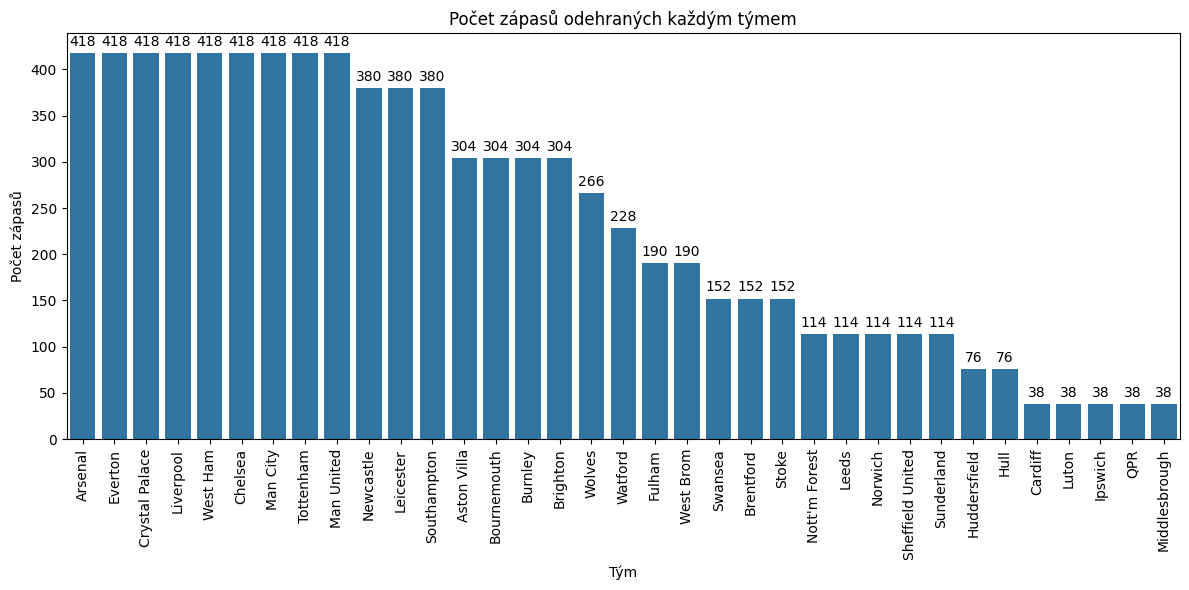

In [21]:
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=value_count_sort.index, y=value_count_sort.values)

# Přidání počtu zápasů na vrchol každého sloupce
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.xticks(rotation=90)
plt.xlabel("Tým")
plt.ylabel("Počet zápasů")
plt.title("Počet zápasů odehraných každým týmem")
plt.tight_layout()
plt.show()

Počet celkových výsledků

In [22]:
ftr_counts = pl1['FTR'].value_counts(normalize=True) * 100
ftr_counts

,proportion
FTR,
H,44.569378
A,32.009569
D,23.421053


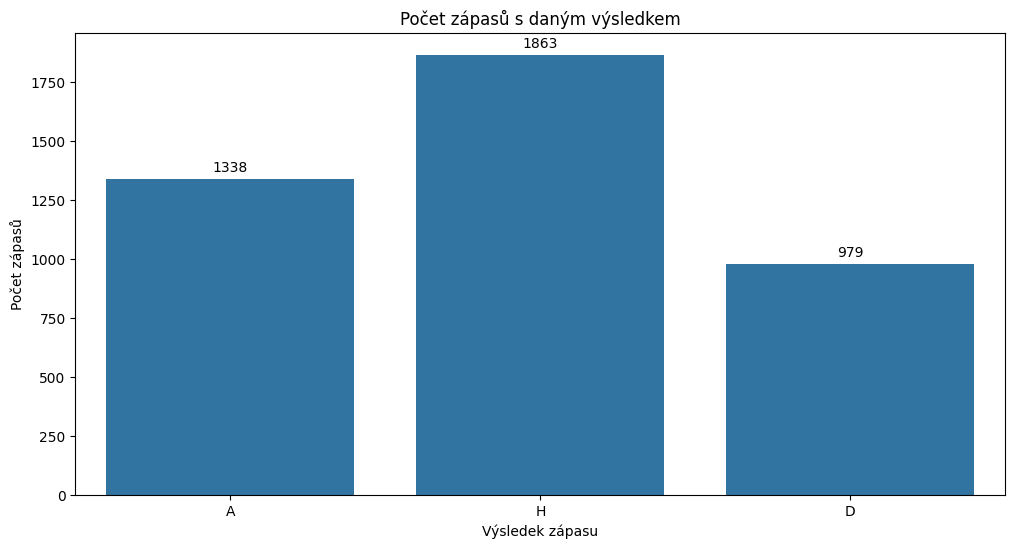

In [23]:
#Počet celkových výsledků
plt.figure(figsize=(12, 6))
bars = sns.countplot(x='FTR', data=pl1)

# Přidání počtu zápasů na vrchol každého sloupce
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Výsledek zápasu")
plt.ylabel("Počet zápasů")
plt.title("Počet zápasů s daným výsledkem")
plt.show()

Počet gólu za sezónu

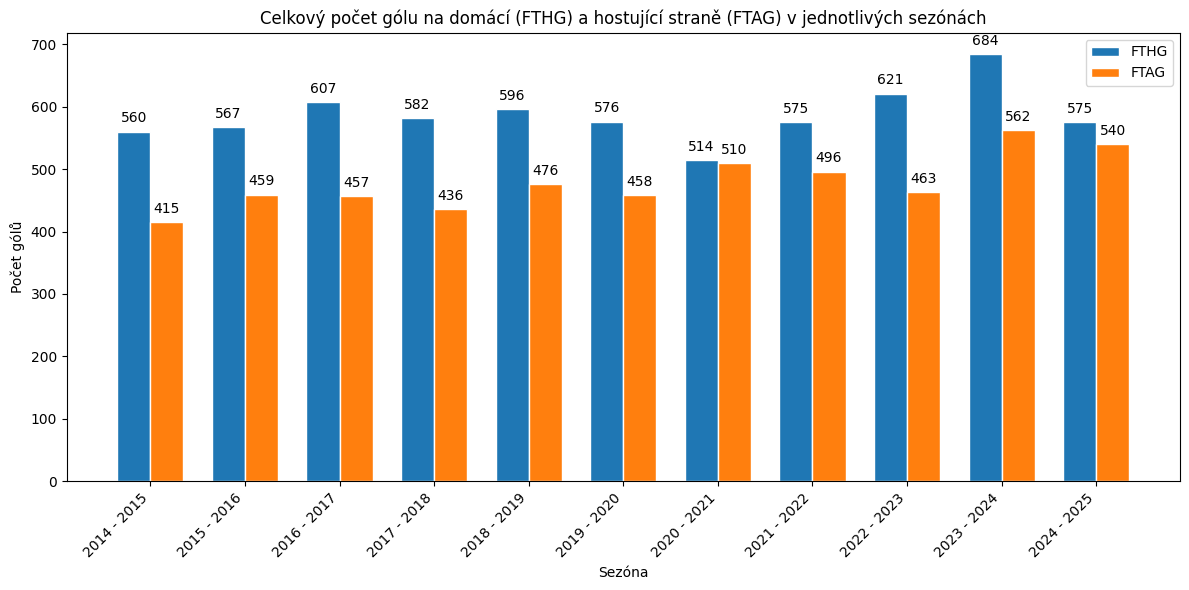

In [24]:
#Počet gólů za sezónu

# Seskupení dat podle sezóny and výpočet součtu FTHG a FTAG
season_stats = pl1.groupby('Season').agg({'FTHG': 'sum', 'FTAG': 'sum'}).reset_index()

# Šířka sloupců
bar_width = 0.35

# Nastavení pozic sloupců na ose x
r1 = np.arange(len(season_stats['Season']))
r2 = [x + bar_width for x in r1]

# Vytváření bar plotu
plt.figure(figsize=(12, 6))
bars1 = plt.bar(r1, season_stats['FTHG'], width=bar_width, edgecolor='white', label='FTHG')
bars2 = plt.bar(r2, season_stats['FTAG'], width=bar_width, edgecolor='white', label='FTAG')

# Přidávání xlabel a xticks na střed párových sloupců
plt.xlabel('Sezóna')
plt.xticks([r + bar_width / 2 for r in range(len(season_stats['Season']))], season_stats['Season'], rotation=45, ha='right')

# Přidávání ylabel
plt.ylabel('Počet gólů')

# Add a legend
plt.legend()

# Add the values on top of the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, round(yval), ha='center', va='bottom')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, round(yval), ha='center', va='bottom')

# Nadpis
plt.title('Celkový počet gólu na domácí (FTHG) a hostující straně (FTAG) v jednotlivých sezónách')

# Upráva layoutu
plt.tight_layout()
plt.show()

Průměrný počet golů za zápas (jednotlivé týmy)

In [25]:
# Celkový počet gólů jako domácí tým
home_goals = pl1.groupby("HomeTeam")["FTHG"].sum()

# Celkový počet gólů jako hostující tým
away_goals = pl1.groupby("AwayTeam")["FTAG"].sum()

# Kombinace gólů jako domácí a hostující tým
total_goals = home_goals + away_goals

# Počet zápasů jako domácí tým
home_matches = pl1["HomeTeam"].value_counts()

# Počet zápasů jako hostující tým
away_matches = pl1["AwayTeam"].value_counts()

# Celkový počet zápasů
total_matches = home_matches + away_matches

# Průměrný počet gólů na zápas
average_goals_per_match = total_goals / total_matches

# Výsledek jako DataFrame pro lepší přehlednost
average_goals_df = average_goals_per_match.reset_index()
average_goals_df.columns = ["Team", "AVGPM"]

# Seřazení podle průměrného počtu gólů (volitelné)
average_goals_df = average_goals_df.sort_values(by="AVGPM", ascending=False)

# Zobrazení výsledku
print(average_goals_df)

                Team     AVGPM
18          Man City  2.346890
16         Liverpool  2.057416
0            Arsenal  1.866029
30         Tottenham  1.818182
7            Chelsea  1.732057
19        Man United  1.562201
3          Brentford  1.500000
15         Leicester  1.447368
33          West Ham  1.375598
17             Luton  1.368421
21         Newcastle  1.352632
14             Leeds  1.333333
1        Aston Villa  1.286184
2        Bournemouth  1.282895
23     Nott'm Forest  1.271930
4           Brighton  1.259868
9            Everton  1.236842
8     Crystal Palace  1.200957
10            Fulham  1.184211
26       Southampton  1.155263
34            Wolves  1.154135
24               QPR  1.105263
27             Stoke  1.085526
31           Watford  1.078947
29           Swansea  1.059211
5            Burnley  0.983553
32         West Brom  0.952632
28        Sunderland  0.947368
13           Ipswich  0.947368
12              Hull  0.921053
6            Cardiff  0.894737
25  Shef

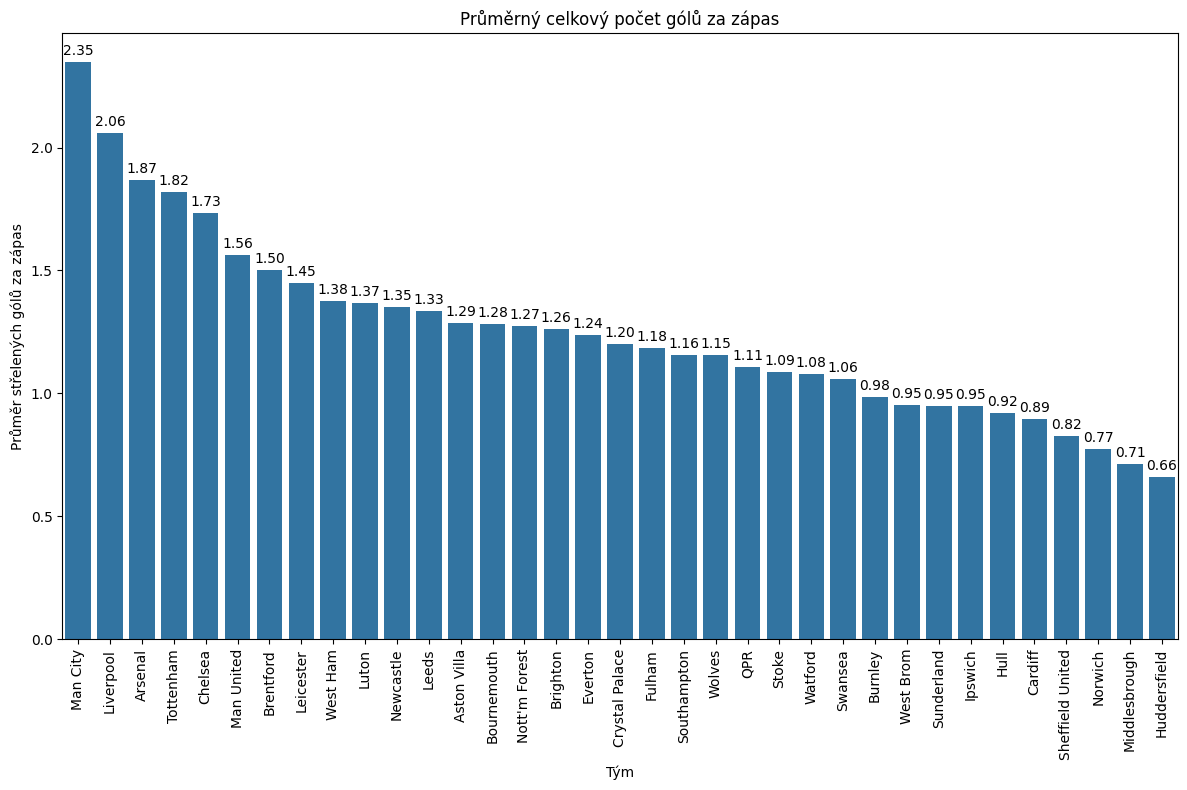

In [26]:
# Graf průměrného počtu gólů na zápas
plt.figure(figsize=(12, 8))
bars = sns.barplot(x='Team', y='AVGPM', data=average_goals_df)

# Hodnoty nad sloupci
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.xticks(rotation=90)
plt.xlabel("Tým")
plt.ylabel("Průměr střelených gólů za zápas")
plt.title("Průměrný celkový počet gólů za zápas")
plt.tight_layout()
plt.show()

Počet gólů podle hracích týdnu (matchweek)

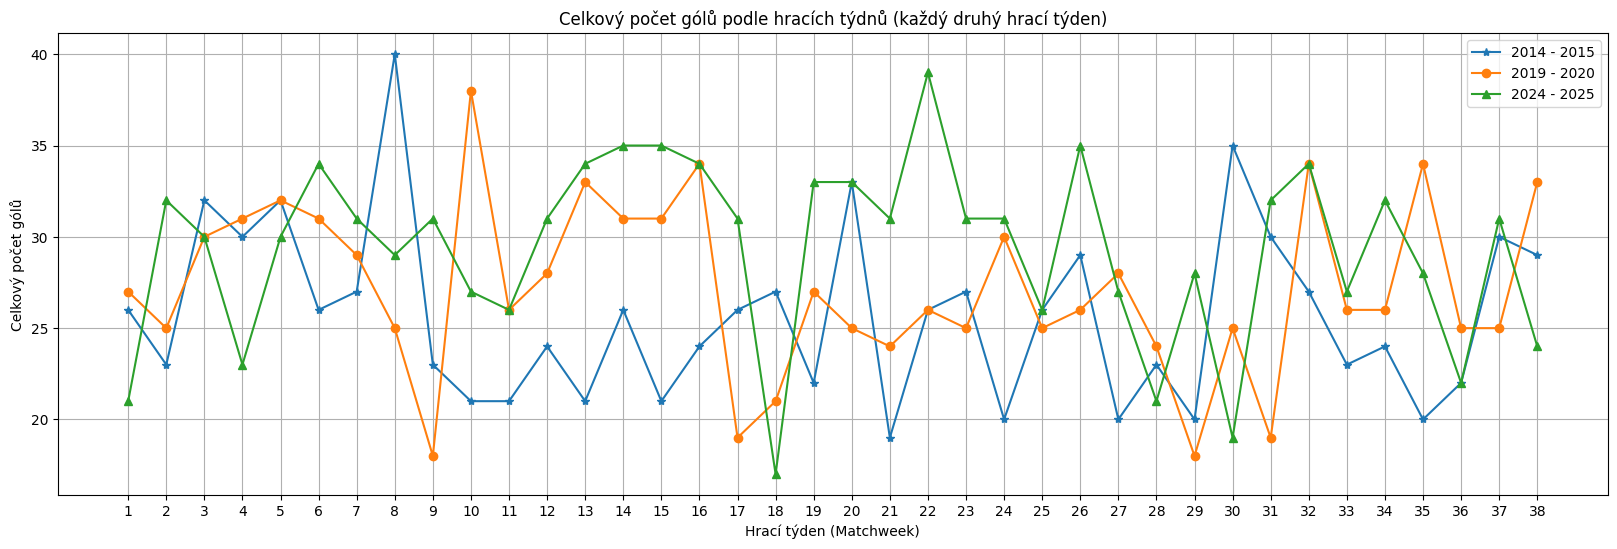

In [27]:
# Převádění sloupce Matchweek na numeric
pl1['Matchweek'] = pd.to_numeric(pl1['Matchweek'], errors='coerce')

# Odfiltrování záznamů, která mají ve sloupci NaN
pl1 = pl1.dropna(subset=['Matchweek'])

# Převedení Matchweek na int
pl1['Matchweek'] = pl1['Matchweek'].astype(int)


# Výběr první, střední a poslední sezóny
first_season = pl1['Season'].unique()[0]
mid_season = pl1['Season'].unique()[5]
last_season = pl1['Season'].unique()[-1]

# Filtrace dat
first_season_data = pl1[pl1['Season'] == first_season]
mid_season_data = pl1[pl1['Season'] == mid_season]
last_season_data = pl1[pl1['Season'] == last_season]

# Seskupení podle Matchweek a celkový součet gólů
first_season_goals = first_season_data.groupby('Matchweek')[['FTHG', 'FTAG']].sum()
mid_season_goals = mid_season_data.groupby('Matchweek')[['FTHG', 'FTAG']].sum()
last_season_goals = last_season_data.groupby('Matchweek')[['FTHG', 'FTAG']].sum()

# Kalkulace celkového počtu gólů za sezónu
first_season_goals['TotalGoals'] = first_season_goals['FTHG'] + first_season_goals['FTAG']
mid_season_goals['TotalGoals'] = mid_season_goals['FTHG'] + mid_season_goals['FTAG']
last_season_goals['TotalGoals'] = last_season_goals['FTHG'] + last_season_goals['FTAG']

# Výběr každého zápasu
first_season_goals = first_season_goals[first_season_goals.index % 1 == 0]
mid_season_goals = mid_season_goals[mid_season_goals.index % 1 == 0]
last_season_goals = last_season_goals[last_season_goals.index % 1 == 0]


# Vytváření vizualizace
plt.figure(figsize=(20, 6))
plt.plot(first_season_goals.index, first_season_goals['TotalGoals'], marker='*', linestyle='-', label=first_season)
plt.plot(mid_season_goals.index, mid_season_goals['TotalGoals'], marker='o', linestyle='-', label=mid_season)
plt.plot(last_season_goals.index, last_season_goals['TotalGoals'], marker='^', linestyle='-', label=last_season)


plt.xlabel('Hrací týden (Matchweek)')
plt.ylabel('Celkový počet gólů')
plt.title('Celkový počet gólů podle hracích týdnů (každý druhý hrací týden)')
plt.xticks(first_season_goals.index)  # nastavení osy x jako číslo Matchweeku
plt.legend()
plt.grid(True)
plt.show()


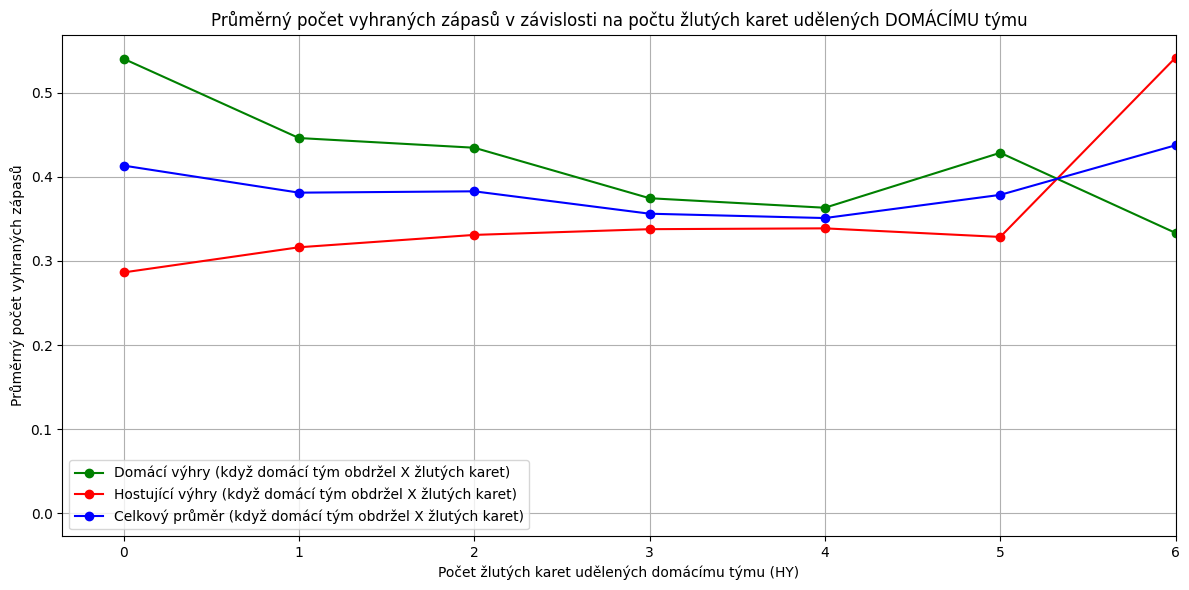

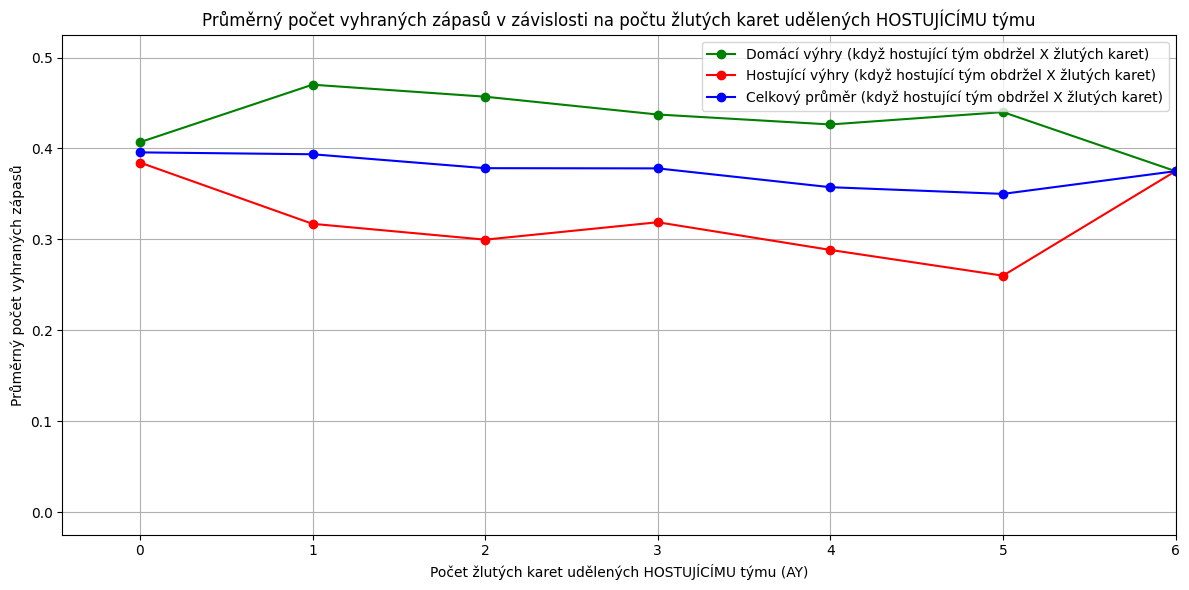

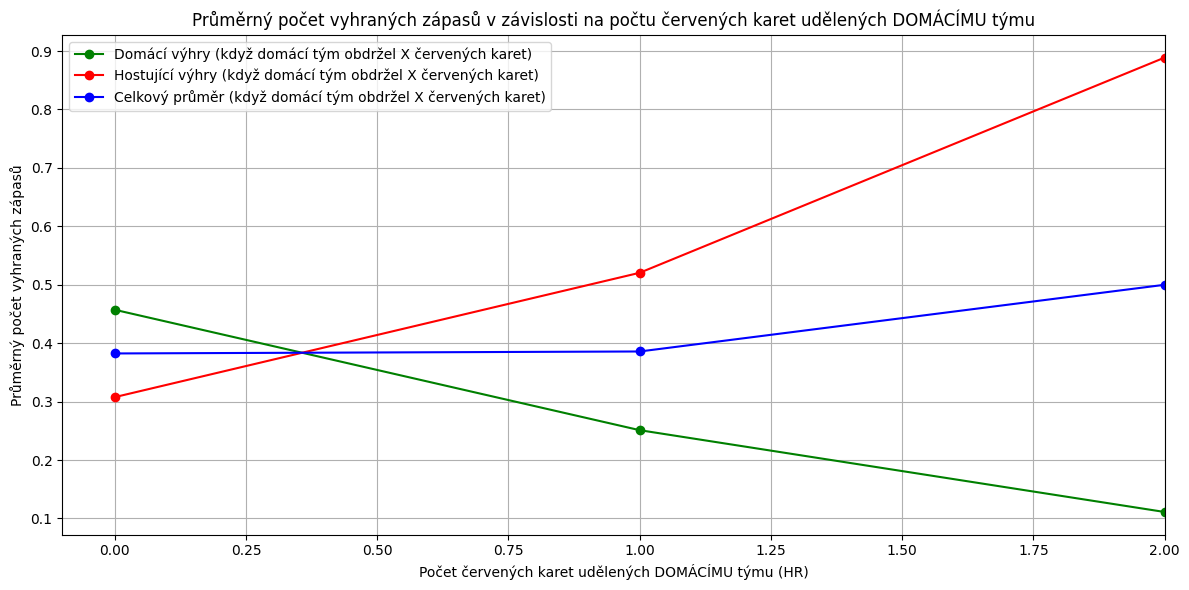

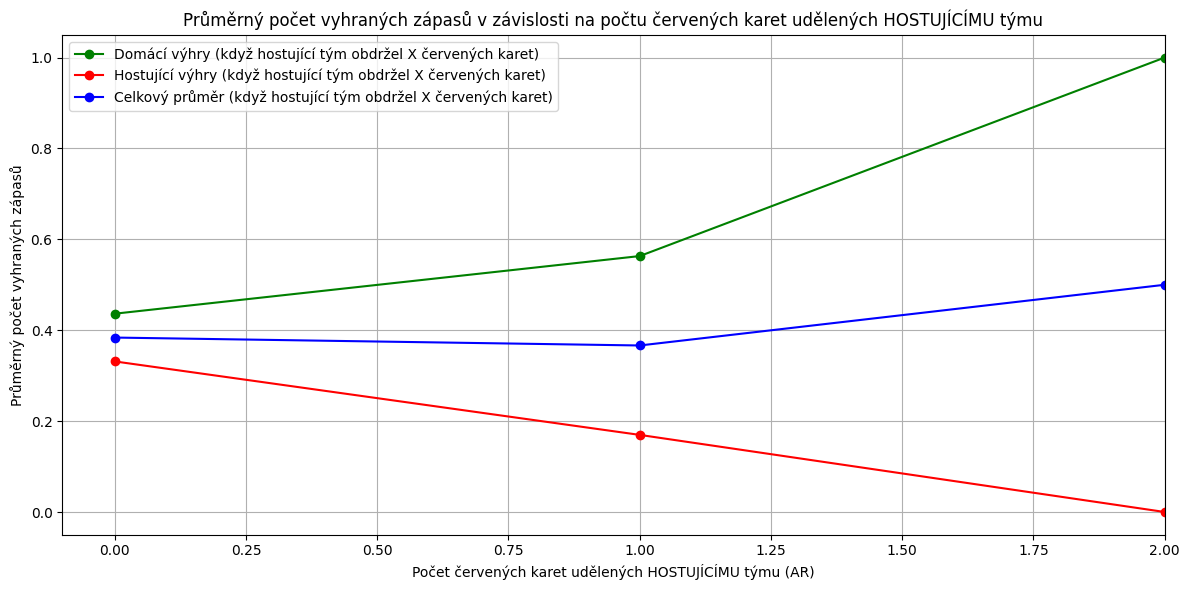

In [30]:
# Add 'HomeWin' and 'AwayWin' columns based on 'FTR'
pl1['HomeWin'] = (pl1['FTR'] == 'H').astype(int)
pl1['AwayWin'] = (pl1['FTR'] == 'A').astype(int)

# Vizualizace pro udělení žlutých karet pro domácí vs. výhry
home_yellow_wins = pl1.groupby("HY")[["HomeWin", "AwayWin"]].mean().reset_index()
home_yellow_wins["TotalWin"] = (home_yellow_wins["HomeWin"] + home_yellow_wins["AwayWin"]) / 2

plt.figure(figsize=(12, 6))
plt.plot(home_yellow_wins["HY"], home_yellow_wins["HomeWin"], marker="o", linestyle="-", color="green", label="Domácí výhry (když domácí tým obdržel X žlutých karet)")
plt.plot(home_yellow_wins["HY"], home_yellow_wins["AwayWin"], marker="o", linestyle="-", color="red", label="Hostující výhry (když domácí tým obdržel X žlutých karet)")
plt.plot(home_yellow_wins["HY"], home_yellow_wins["TotalWin"], marker="o", linestyle="-", color="blue", label="Celkový průměr (když domácí tým obdržel X žlutých karet)")
plt.xlim(right=6) # Limitace osy x pro lepší čítelnost dle obvyklého počtu žlutých karet za zápas
plt.xlabel("Počet žlutých karet udělených domácímu týmu (HY)")
plt.ylabel("Průměrný počet vyhraných zápasů")
plt.title("Průměrný počet vyhraných zápasů v závislosti na počtu žlutých karet udělených DOMÁCÍMU týmu")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Vizualizace pro udělení žlutých karet pro hosté vs. výhry
away_yellow_wins = pl1.groupby("AY")[["HomeWin", "AwayWin"]].mean().reset_index()
away_yellow_wins["TotalWin"] = (away_yellow_wins["HomeWin"] + away_yellow_wins["AwayWin"]) / 2

plt.figure(figsize=(12, 6))
plt.plot(away_yellow_wins["AY"], away_yellow_wins["HomeWin"], marker="o", linestyle="-", color="green", label="Domácí výhry (když hostující tým obdržel X žlutých karet)")
plt.plot(away_yellow_wins["AY"], away_yellow_wins["AwayWin"], marker="o", linestyle="-", color="red", label="Hostující výhry (když hostující tým obdržel X žlutých karet)")
plt.plot(away_yellow_wins["AY"], away_yellow_wins["TotalWin"], marker="o", linestyle="-", color="blue", label="Celkový průměr (když hostující tým obdržel X žlutých karet)")
plt.xlim(right=6) # Limitace osy x pro lepší čítelnost dle obvyklého počtu žlutých karet za zápas
plt.xlabel("Počet žlutých karet udělených HOSTUJÍCÍMU týmu (AY)")
plt.ylabel("Průměrný počet vyhraných zápasů")
plt.title("Průměrný počet vyhraných zápasů v závislosti na počtu žlutých karet udělených HOSTUJÍCÍMU týmu")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Vizualizace pro udělení červených karet pro domácí vs. výhry
home_red_wins = pl1.groupby("HR")[["HomeWin", "AwayWin"]].mean().reset_index()
home_red_wins["TotalWin"] = (home_red_wins["HomeWin"] + home_red_wins["AwayWin"]) / 2

plt.figure(figsize=(12, 6))
plt.plot(home_red_wins["HR"], home_red_wins["HomeWin"], marker="o", linestyle="-", color="green", label="Domácí výhry (když domácí tým obdržel X červených karet)")
plt.plot(home_red_wins["HR"], home_red_wins["AwayWin"], marker="o", linestyle="-", color="red", label="Hostující výhry (když domácí tým obdržel X červených karet)")
plt.plot(home_red_wins["HR"], home_red_wins["TotalWin"], marker="o", linestyle="-", color="blue", label="Celkový průměr (když domácí tým obdržel X červených karet)")
plt.xlim(right=2) # Limitace osy x pro lepší čitelnost
plt.xlabel("Počet červených karet udělených DOMÁCÍMU týmu (HR)")
plt.ylabel("Průměrný počet vyhraných zápasů")
plt.title("Průměrný počet vyhraných zápasů v závislosti na počtu červených karet udělených DOMÁCÍMU týmu")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Vizualizace pro udělení červených karet pro hosté vs. výhry
away_red_wins = pl1.groupby("AR")[["HomeWin", "AwayWin"]].mean().reset_index()
away_red_wins["TotalWin"] = (away_red_wins["HomeWin"] + away_red_wins["AwayWin"]) / 2

plt.figure(figsize=(12, 6))
plt.plot(away_red_wins["AR"], away_red_wins["HomeWin"], marker="o", linestyle="-", color="green", label="Domácí výhry (když hostující tým obdržel X červených karet)")
plt.plot(away_red_wins["AR"], away_red_wins["AwayWin"], marker="o", linestyle="-", color="red", label="Hostující výhry (když hostující tým obdržel X červených karet)")
plt.plot(away_red_wins["AR"], away_red_wins["TotalWin"], marker="o", linestyle="-", color="blue", label="Celkový průměr (když hostující tým obdržel X červených karet)")
plt.xlim(right=2) # Limitace osy x pro lepší čitelnost
plt.xlabel("Počet červených karet udělených HOSTUJÍCÍMU týmu (AR)")
plt.ylabel("Průměrný počet vyhraných zápasů")
plt.title("Průměrný počet vyhraných zápasů v závislosti na počtu červených karet udělených HOSTUJÍCÍMU týmu")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Korelační matice

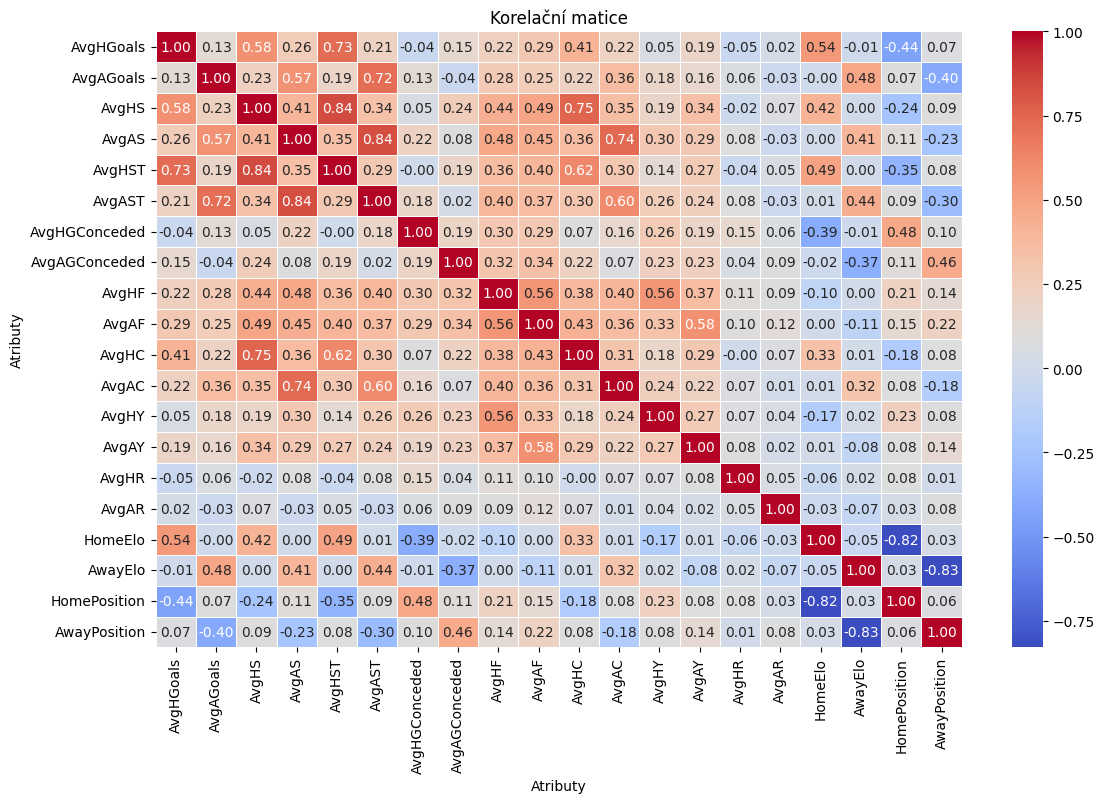

In [32]:
correlation_matrix = pl1.drop(["Date", "HomeTeam", "AwayTeam","FTHG", "FTAG", "HTHG", "HTAG", "FTR", "HTR", "HS", "AS","HST", "AST", "HSOT", "ASOT", "FTR - team", "Season", "Season_start_year", "Matchweek", "HF", "AF", "HY", "AY", "HR", "AR", "HC", "AC", "HomeWin", "AwayWin"], axis=1).corr()

plt.figure(figsize=(13, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelační matice")
plt.xlabel("Atributy")
plt.ylabel("Atributy")
plt.show()

# **Modely strojového učení**


načtení knihoven

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance
from itertools import cycle
from imblearn.over_sampling import SMOTE

Pro přípravu modelu strojového učení načteme veškeré dostupné atributy

In [34]:
pl1.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
       'HR', 'AR', 'HSOT', 'ASOT', 'Matchweek', 'FTR - team', 'Season',
       'Season_start_year', 'AvgHGoals', 'AvgAGoals', 'AvgHS', 'AvgAS',
       'AvgHST', 'AvgAST', 'AvgHGConceded', 'AvgAGConceded', 'AvgHF', 'AvgAF',
       'AvgHC', 'AvgAC', 'AvgHY', 'AvgAY', 'AvgHR', 'AvgAR', 'HomeElo',
       'AwayElo', 'HomePosition', 'AwayPosition', 'HomeWin', 'AwayWin'],
      dtype='object')

## **Logistická regrese**


Koeficienty pro třídu 'A' (vs ostatní):
AwayElo          0.568064
AvgAS            0.341633
AwayPosition     0.109967
AvgAY            0.088129
AvgHGoals        0.052016
AvgHF            0.047860
AvgHC            0.042450
AvgAR           -0.000445
AvgHGConceded   -0.005113
AvgHY           -0.039566
AvgAC           -0.049016
AvgHR           -0.057130
AvgAGConceded   -0.060571
AvgAGoals       -0.065877
AvgHST          -0.073550
AvgAST          -0.075160
HomePosition    -0.097839
AvgAF           -0.113737
AvgHS           -0.210836
HomeElo         -0.672654
dtype: float64

Koeficienty pro třídu 'D' (vs ostatní):
AvgAF            0.116250
AvgAGoals        0.104228
AvgAST           0.099150
AvgHS            0.094332
AvgAC            0.061539
AvgHR            0.047476
AvgAGConceded    0.028920
AvgHY            0.025582
AvgHGConceded    0.023569
AvgHF            0.007740
AvgHC           -0.014279
AvgAR           -0.029392
AvgHGoals       -0.039845
AvgHST          -0.069921
AvgAY           -0.

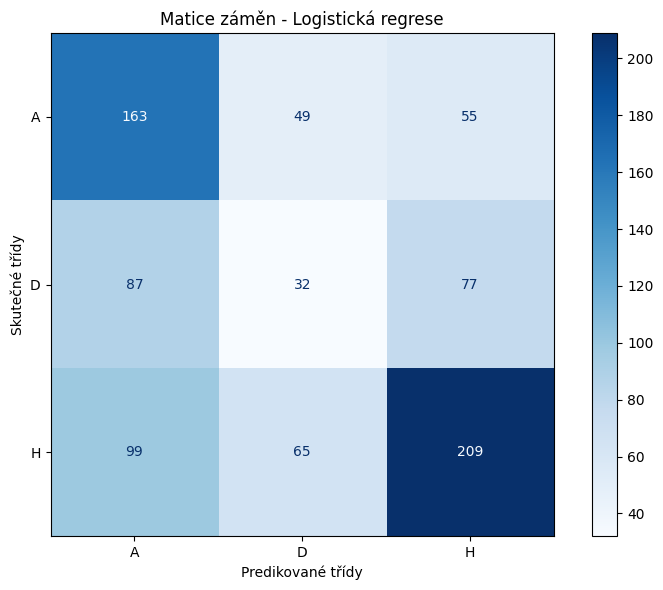

In [35]:
df_logr_smote = pl1.copy()

target_cols = 'FTR'
feature_cols = ['AvgHGoals', 'AvgAGoals', 'AvgHS', 'AvgAS', 'AvgHST', 'AvgAST',
                'AvgHGConceded', 'AvgAGConceded', 'AvgHF', 'AvgAF', 'AvgHC',
                'AvgAC', 'AvgHY', 'AvgAY', 'AvgHR', 'AvgAR',
                'HomeElo', 'AwayElo', 'HomePosition', 'AwayPosition']

X = df_logr_smote[feature_cols].copy()
y = df_logr_smote[target_cols].copy()

# No LabelEncoder needed here for the target variable as OneVsRestClassifier can handle string labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Použití SMOTE na trénovací data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer, feature_cols)
    ])

logr_smote = Pipeline(steps=[
    ('transformer', transformer),
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000))) # Increased max_iter for convergence
])

# Trénování modelu na datech po použití SMOTE
logr_smote.fit(X_train_smote, y_train_smote)

y_pred_logr_smote = logr_smote.predict(X_test)

# Zobrazení váhy jednotlivých atributů
lr_model_smote = logr_smote.named_steps['classifier'].estimators_

# Získání koeficientů
# Pro mnohotřídný případ One-vs-Rest bude .coef_ matice (n_tříd, n_rysů)
lr_coefficients_smote = [estimator.coef_ for estimator in lr_model_smote]

# Získání jmen tříd pro Logistickou regresi přímo z modelu
lr_classes_smote = logr_smote.named_steps['classifier'].classes_

# Procházíme jednotlivé třídy a zobrazíme koeficienty pro každou z nich
for i, class_name in enumerate(lr_classes_smote):
    print(f"\nKoeficienty pro třídu '{class_name}' (vs ostatní):")
    coef_series_smote = pd.Series(lr_coefficients_smote[i][0], index=feature_cols)
    print(coef_series_smote.sort_values(ascending=False))

print("\nVyhodnocení modelu po SMOTE:")
class_labels = lr_classes_smote # Využítí labelu přímo od modelu
print("mapování hodnot [0 1 2]:", class_labels)
print(classification_report(y_test, y_pred_logr_smote, target_names=class_labels))

# Confusion matrix/ matice záměn
print("\nMatice záměn - Logistická regrese")
print("Řádky: Skutečné třídy, Sloupce: Predikované třídy")
fig, ax = plt.subplots(figsize=(8, 6))
# Use y_test (original string labels) and y_pred_logr_smote (predicted string labels)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logr_smote, ax=ax, display_labels=class_labels, cmap='Blues')
ax.set_title('Matice záměn - Logistická regrese')
ax.set_xlabel('Predikované třídy')
ax.set_ylabel('Skutečné třídy')
plt.tight_layout()
plt.show()

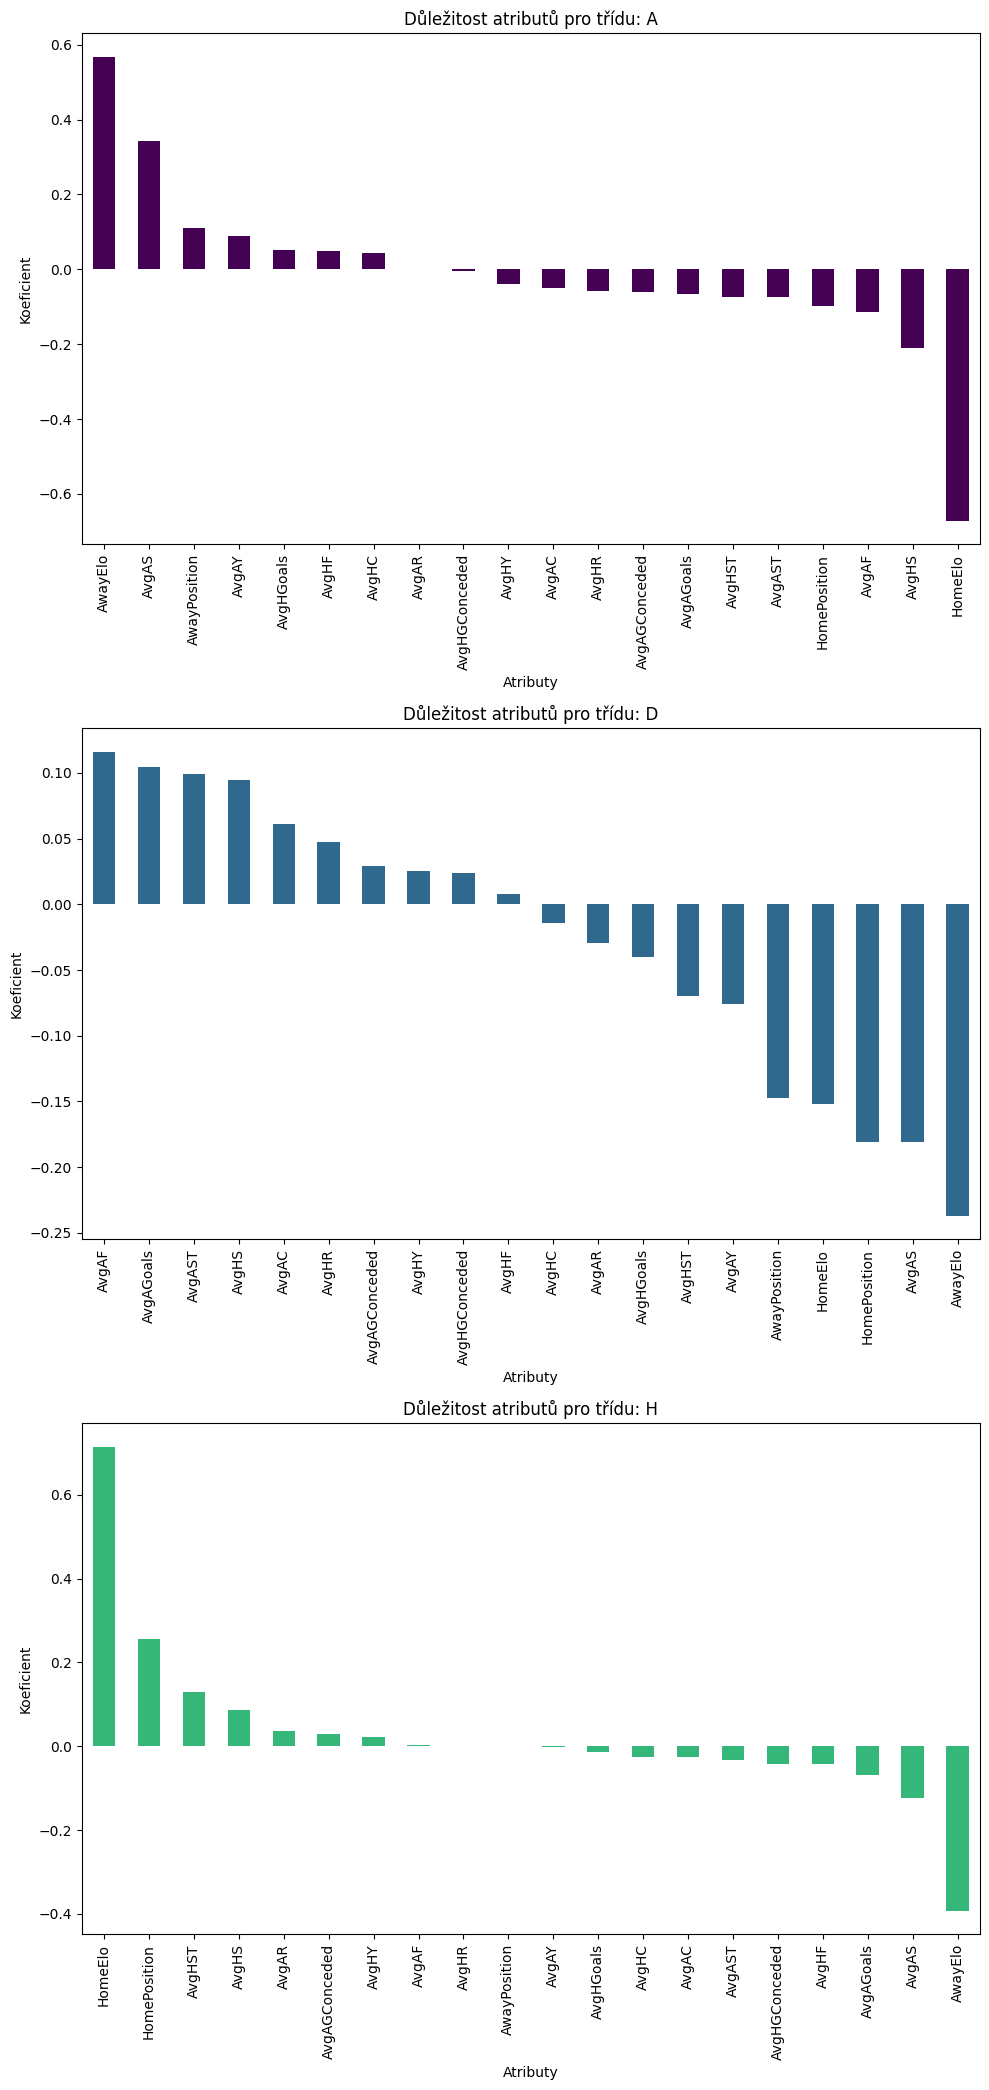

In [36]:
# Kontrola jestli lr_coefficients_smote a lr_classes_smote existují
if 'lr_coefficients_smote' in globals() and 'lr_classes_smote' in globals():

    # Počet tříd
    n_classes = len(lr_classes_smote)
    n_features = len(feature_cols)

    fig, axes = plt.subplots(nrows=n_classes, ncols=1, figsize=(10, 7 * n_classes), sharex=False)

    if n_classes > 1:
        axes = axes.flatten()

    # Iterace přes třídy
    for i, class_name in enumerate(lr_classes_smote):
        ax = axes[i]
        coef_series = pd.Series(lr_coefficients_smote[i][0], index=feature_cols)
        coef_series = coef_series.sort_values(ascending=False)

        # Vytvoření plots
        coef_series.plot.bar(ax=ax, color=plt.cm.viridis(i / n_classes))
        ax.set_title(f'Důležitost atributů pro třídu: {class_name}')
        ax.set_xlabel("Atributy")
        ax.set_ylabel("Koeficient")
        ax.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()
else:
    print("Koeficienty modelu Logistic Regression nejsou dostupné. Spusťte prosím předchozí buňky.")

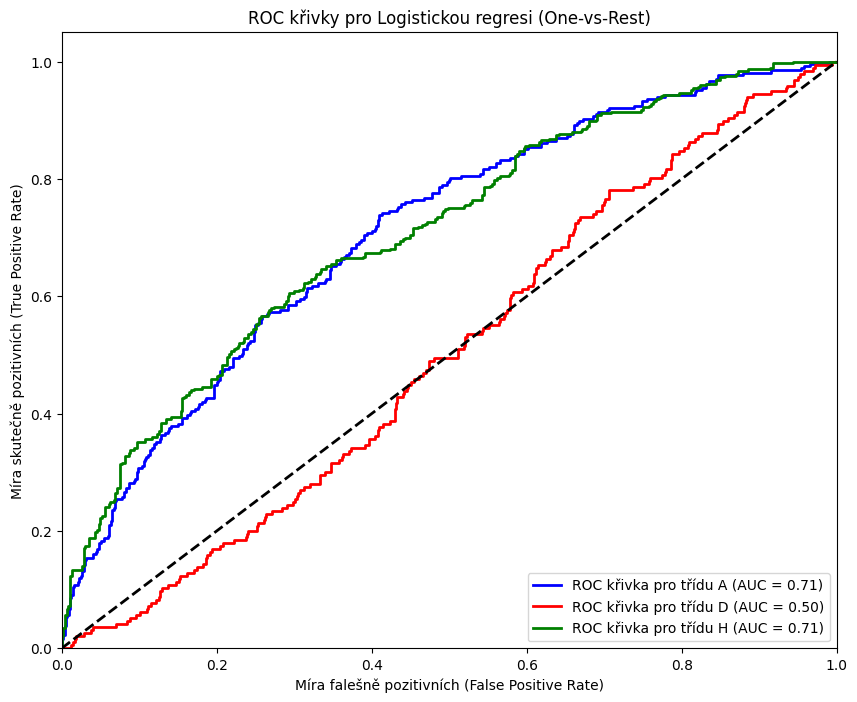


AUC pro Logistickou regresi:
Třída 'A': 0.71
Třída 'D': 0.50
Třída 'H': 0.71


In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Vypočet pravděpodobnosti pro každou třídu na testovacích datech
y_prob_logr = logr_smote.predict_proba(X_test)

# Binarizace skutečných hodnot použítí popisků od 'y_test'
# a ujištční, že třídy se rovnájí těm popiskům
# U 'y_test' se předpokláda ['A', 'D', 'H')
y_test_bin = label_binarize(y_test, classes=class_labels)
n_classes = y_test_bin.shape[1]

# Vypočet ROC křivky a AUC pro každou třídu
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # Kontrola jestli se vyskytuje nějaký pozitivní vzorek pro současnou třídy, aby se zamezilo chybám
    if np.sum(y_test_bin[:, i]) == 0:
        fpr[i] = [0, 1]
        tpr[i] = [0, 1]
        roc_auc[i] = np.nan # Indikace nedefinovaného AUC
    else:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_logr[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Vykreslení ROC křivek pro každou třídu
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    if not np.isnan(roc_auc[i]): # Jenom plots, které mají definovaný AUC
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC křivka pro třídu {0} (AUC = {1:0.2f})'\
                 .format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Míra falešně pozitivních (False Positive Rate)')
plt.ylabel('Míra skutečně pozitivních (True Positive Rate)')
plt.title('ROC křivky pro Logistickou regresi (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# Vytisknutí AUC pro každou třídu
print("\nAUC pro Logistickou regresi:")
for i in range(n_classes):
    # Print AUC jen, když je definovaný
    if not np.isnan(roc_auc[i]):
        print(f"Třída '{class_labels[i]}': {roc_auc[i]:0.2f}")
    else:
        print(f"Třída '{class_labels[i]}': AUC není definována (žádné kladné vzorky ve třídě).")

## **XGBoost**




Důležitost atributů v modelu XGBoost:
AvgHR            0.074079
AvgAR            0.072543
AvgHGConceded    0.055010
HomeElo          0.052668
AvgHY            0.051453
AvgAC            0.051366
AvgAST           0.048934
AvgHST           0.048829
AvgAF            0.048555
AvgHGoals        0.047977
AvgHS            0.047092
AvgHC            0.046794
AvgAGConceded    0.046783
AvgAGoals        0.046454
AvgAY            0.046186
AvgAS            0.045999
AvgHF            0.045315
AwayElo          0.044801
HomePosition     0.041313
AwayPosition     0.037847
dtype: float32

Vyhodnocení modelu:
mapování hodnot [0 1 2]: ['A' 'D' 'H']
              precision    recall  f1-score   support

           A       0.45      0.48      0.46       267
           D       0.26      0.16      0.20       196
           H       0.55      0.64      0.60       373

    accuracy                           0.48       836
   macro avg       0.42      0.43      0.42       836
weighted avg       0.45      0.48      0

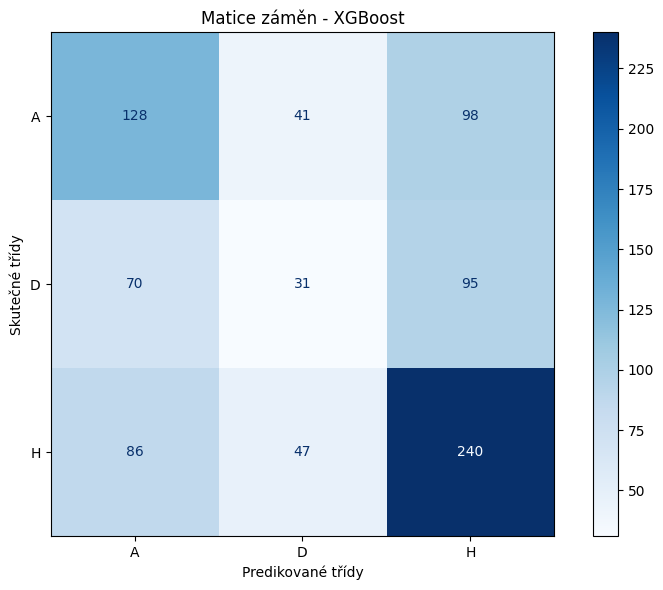

In [38]:
df_xgboost = pl1.copy()

target_cols = 'FTR'
feature_cols = ['AvgHGoals', 'AvgAGoals', 'AvgHS', 'AvgAS', 'AvgHST', 'AvgAST',
                'AvgHGConceded', 'AvgAGConceded', 'AvgHF', 'AvgAF', 'AvgHC',
                'AvgAC', 'AvgHY', 'AvgAY', 'AvgHR', 'AvgAR',
                'HomeElo', 'AwayElo', 'HomePosition', 'AwayPosition']

X = df_xgboost[feature_cols].copy()
y = df_xgboost[target_cols].copy()

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

xgboost = Pipeline(steps=[
    ('classifier', xgb.XGBClassifier(objective='multi:softmax', n_estimators=1000, num_class=3))
])

xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)

# Zobrazení důležitosti jednotlivých atributů
xgboost_model = xgboost.named_steps['classifier']

# Získání důležitosti rysů
feature_importances = xgboost_model.feature_importances_

# Získání jmen rysů po transformaci
transformed_feature_names = feature_cols

# Vytvoření Series pro lepší zobrazení
importance_series = pd.Series(feature_importances, index=transformed_feature_names)

print("\nDůležitost atributů v modelu XGBoost:")
print(importance_series.sort_values(ascending=False))

# Dekódování predikcí zpět na původní popisky tříd
y_pred_xgboost_decoded = le.inverse_transform(y_pred_xgboost)
y_test_decoded = le.inverse_transform(y_test)

print("\nVyhodnocení modelu:")
print("mapování hodnot [0 1 2]:", le.classes_)
class_labels = le.classes_ # Použijeme popisky z LabelEncoderu
print(classification_report(y_test_decoded, y_pred_xgboost_decoded, target_names=class_labels)) # Použijeme target_names

# Confusion matrix/ matice záměn
print("\nMatice záměn - XGBoost")
print("Řádky: Skutečné třídy, Sloupce: Predikované třídy")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test_decoded, y_pred_xgboost_decoded, ax=ax, display_labels=class_labels, cmap='Blues')
ax.set_title('Matice záměn - XGBoost')
ax.set_xlabel('Predikované třídy')
ax.set_ylabel('Skutečné třídy')
plt.tight_layout()
plt.show()

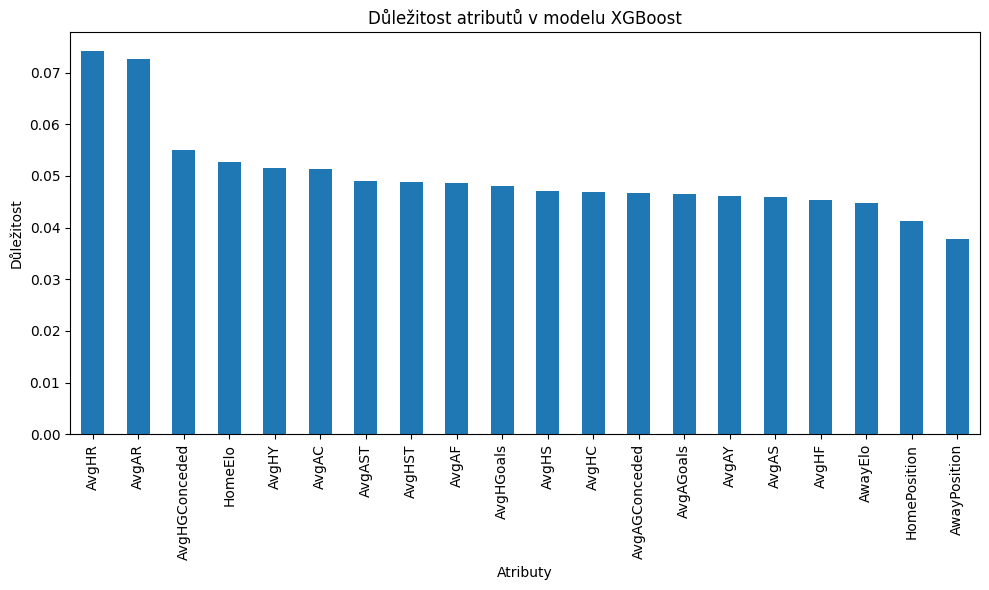

In [39]:
# Vizualizace důležitosti atributů
plt.figure(figsize=(10, 6))
importance_series.sort_values(ascending=False).plot.bar() # Seřazení před vykreslením
plt.title("Důležitost atributů v modelu XGBoost")
plt.xlabel("Atributy")
plt.ylabel("Důležitost")
plt.tight_layout()
plt.show()

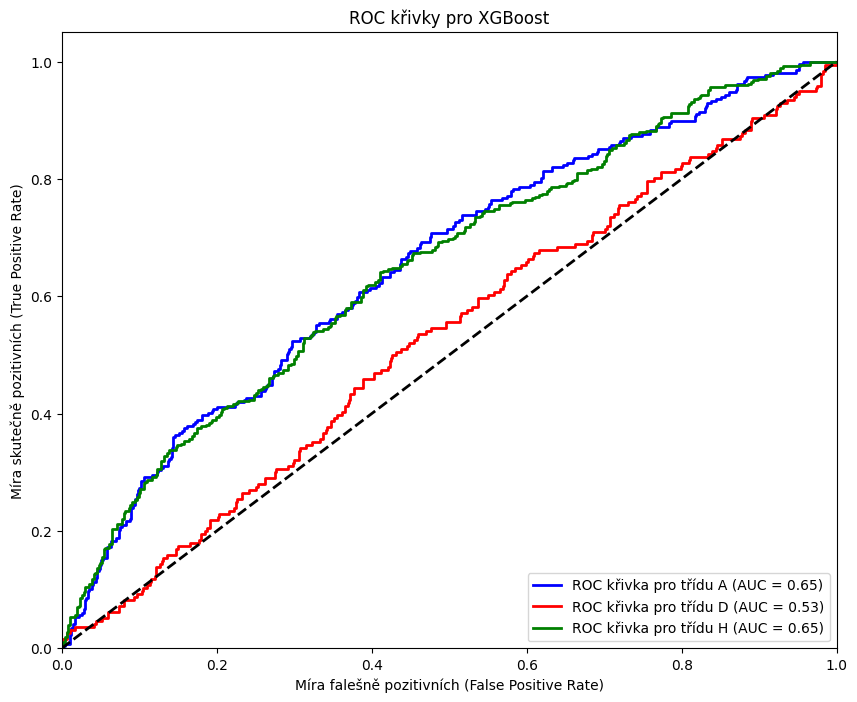


AUC pro XGBoost:
Třída 'A': 0.65
Třída 'D': 0.53
Třída 'H': 0.65


In [40]:
# Vypočet pravděpodobnosti pro každou třídu na testovacích datech
y_prob_xgboost = xgboost.predict_proba(X_test)

# Binarizace skutečných hodnot
y_test_bin = label_binarize(y_test, classes=np.unique(y_test)) # Použijeme np.unique(y_test) pro získání tříd z testovacích dat
n_classes = y_test_bin.shape[1]

# Vypočet ROC křivky a AUC pro každou třídu
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_xgboost[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vykreslení ROC křivek pro každou třídu
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green']) # Barvy podle počtu tříd (3 třídy: A, D, H)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC křivka pro třídu {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Míra falešně pozitivních (False Positive Rate)')
plt.ylabel('Míra skutečně pozitivních (True Positive Rate)')
plt.title('ROC křivky pro XGBoost')
plt.legend(loc="lower right")
plt.show()

# Vytisknutí AUC pro každou třídu
print("\nAUC pro XGBoost:")
for i in range(n_classes):
    print(f"Třída '{le.classes_[i]}': {roc_auc[i]:0.2f}")

## **SVM**


Vyhodnocení modelu po SMOTE:
mapování hodnot [0 1 2]: ['A' 'D' 'H']
              precision    recall  f1-score   support

           A       0.48      0.52      0.50       267
           D       0.26      0.32      0.29       196
           H       0.63      0.51      0.57       373

    accuracy                           0.47       836
   macro avg       0.46      0.45      0.45       836
weighted avg       0.50      0.47      0.48       836


Matice záměn - SVM
Řádky: Skutečné třídy, Sloupce: Predikované třídy


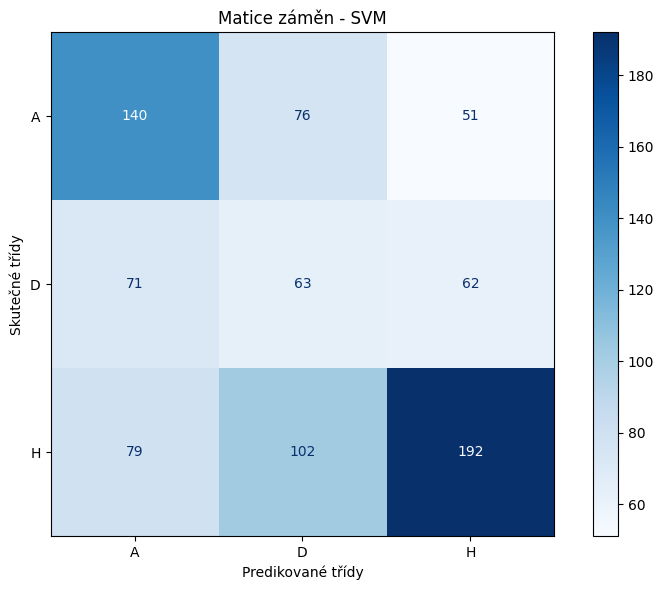

In [41]:
df_svm_smote = pl1.copy()

target_cols = 'FTR'

feature_cols = ['AvgHGoals', 'AvgAGoals', 'AvgHS', 'AvgAS', 'AvgHST', 'AvgAST',
                'AvgHGConceded', 'AvgAGConceded', 'AvgHF', 'AvgAF', 'AvgHC',
                'AvgAC', 'AvgHY', 'AvgAY', 'AvgHR', 'AvgAR',
                'HomeElo', 'AwayElo', 'HomePosition', 'AwayPosition']

X = df_svm_smote[feature_cols].copy()
y = df_svm_smote[target_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Použití SMOTE na trénovací data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer, feature_cols)
    ])

# Využítí preprocesoru v SVM pipeline
SVM_smote = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(decision_function_shape='ovr')) # Odstranění class_weight='balanced' jelikož SMOTE řeší nerovnoměrnost
    ])

# Trénování modelu na SMOTE-resampled data
SVM_smote.fit(X_train_smote, y_train_smote)

y_pred_SVM_smote = SVM_smote.predict(X_test)

print("\nVyhodnocení modelu po SMOTE:")
print("mapování hodnot [0 1 2]:", le.classes_)
class_labels = le.classes_ # Použití popisků z LabelEncoder
print(classification_report(y_test_decoded, y_pred_SVM_smote, target_names=class_labels))

# Confusion matrix/ matice záměn
print("\nMatice záměn - SVM")
print("Řádky: Skutečné třídy, Sloupce: Predikované třídy")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test_decoded, y_pred_SVM_smote, ax=ax, display_labels=class_labels, cmap='Blues')
ax.set_title('Matice záměn - SVM')
ax.set_xlabel('Predikované třídy')
ax.set_ylabel('Skutečné třídy')
plt.tight_layout()
plt.show()

In [ ]:
# Kalkulace permutační důležitosti
result_smote = permutation_importance(SVM_smote, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Získání průměrů feature importance a jejich seřazení
sorted_idx_smote = result_smote.importances_mean.argsort()
sorted_idx_smote_descending = sorted_idx_smote[::-1]
feature_importances_smote = pd.Series(result_smote.importances_mean[sorted_idx_smote_descending], index=X_test.columns[sorted_idx_smote_descending])

print("\nPermutation Feature Importance for SVM:")
print(feature_importances_smote)

# Vizualizace permutační důležitosti
plt.figure(figsize=(10, 6))
feature_importances_smote.plot.bar()
plt.title("Důležitost atributů v modelu SVM")
plt.xlabel("Atributy")
plt.ylabel("Důležitost")
plt.tight_layout()
plt.show()

In [ ]:
# Vypočet pravděpodobnosti pro každou třídu na testovacích datech
# Pro SVM s 'ovr' decision_function_shape použijeme decision_function
y_score_svm_smote = SVM_smote.decision_function(X_test)

# Binarizace skutečných hodnot
# Použijeme np.unique(y_test) pro získání tříd z testovacích dat
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Vypočet ROC křivky a AUC pro každou třídu
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_svm_smote[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vykreslení ROC křivek pro každou třídu
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green']) # Upravte barvy podle počtu tříd (3 třídy: A, D, H)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC křivka pro třídu {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i])) # Použití le.classes_[i] pro popisky tříd

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Míra falešně pozitivních (False Positive Rate)')
plt.ylabel('Míra skutečně pozitivních (True Positive Rate)')
plt.title('ROC křivky pro SVM')
plt.legend(loc="lower right")
plt.show()

# Vytisknutí AUC pro každou třídu
print("\nAUC pro SVM:")
for i in range(n_classes):
    print(f"Třída '{le.classes_[i]}': {roc_auc[i]:0.2f}")

## **Naive Bayes**

In [ ]:
df_nb = pl1.copy()

target_cols = "FTR"

feature_cols = ['AvgHGoals', 'AvgAGoals', 'AvgHS', 'AvgAS', 'AvgHST', 'AvgAST',
                'AvgHGConceded', 'AvgAGConceded', 'AvgHF', 'AvgAF', 'AvgHC',
                'AvgAC', 'AvgHY', 'AvgAY', 'AvgHR', 'AvgAR',
                'HomeElo', 'AwayElo', 'HomePosition', 'AwayPosition']
X = df_nb[feature_cols]
y = df_nb[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

nb = Pipeline(steps=[
    ('classifier', GaussianNB(priors=[1/3, 1/3, 1/3]))
])

nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)


print("\nVyhodnocení modelu:")
print("mapování hodnot [0 1 2]:", le.classes_)
class_labels = le.classes_ # Použijeme popisky z LabelEncoderu
print(classification_report(y_test_decoded, y_pred_nb, target_names=class_labels)) # Použijeme target_names

# Confusion matrix/ matice záměn
print("\nMatice záměn - Naive Bayes")
print("Řádky: Skutečné třídy, Sloupce: Predikované třídy")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test_decoded, y_pred_nb, ax=ax, display_labels=class_labels, cmap='Blues')
ax.set_title('Matice záměn - Naivní Bayes')
ax.set_xlabel('Predikované třídy')
ax.set_ylabel('Skutečné třídy')
plt.tight_layout()
plt.show()

In [ ]:
# Kalkulace permutační důležitosti
# Note: This can take some time depending on the size of your dataset and the complexity of the model
result = permutation_importance(nb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Získání průměrů feature importance a jejich seřazení
sorted_idx = result.importances_mean.argsort()
sorted_idx_descending = sorted_idx[::-1]
feature_importances = pd.Series(result.importances_mean[sorted_idx_descending], index=X_test.columns[sorted_idx_descending])

print("\nPermutation Feature Importance for Naive Bayes:")
print(feature_importances)

# Vizualizace permutační důležitosti
plt.figure(figsize=(10, 6))
feature_importances.plot.bar()
plt.title("Důležitost atributů v modelu Naive Bayes")
plt.xlabel("Atributy")
plt.ylabel("Důležitost")
plt.tight_layout()
plt.show()

In [ ]:
# Vypočet pravděpodobnosti pro každou třídu na testovacích datech
# Pro Gaussian Naive Bayes použijeme predict_proba
y_prob_nb = nb.predict_proba(X_test)

# Binarizace skutečných hodnot
# Použijeme np.unique(y_test) pro získání tříd z testovacích dat
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Vypočet ROC křivky a AUC pro každou třídu
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_nb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vykreslení ROC křivek pro každou třídu
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green']) # Barvy podle počtu tříd (3 třídy: A, D, H)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC křivka pro třídu {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Míra falešně pozitivních (False Positive Rate)')
plt.ylabel('Míra skutečně pozitivních (True Positive Rate)')
plt.title('ROC křivky pro Naivní Bayes')
plt.legend(loc="lower right")
plt.show()

# Vytisknutí AUC pro každou třídu
print("\nAUC pro Naivní Bayes:")
for i in range(n_classes):
    print(f"Třída '{le.classes_[i]}': {roc_auc[i]:0.2f}")